# 1. Introduction

Voir présentation

# 2. Démarche méthodologique

Voir présentation

# 3. Exploration des données

## <a name="C31">3.1 Chargement<a>

### <a name="C2311">3.1.1 Importation des librairies utiles et options<a>

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import matplotlib.pyplot as plt
import cv2
import json
import tqdm
from IPython.display import clear_output
from wordcloud import WordCloud
from collections import Counter
import random

import  time, random
from IPython.display import clear_output
import seaborn as sns

#Augmentation des données
import imgaug as ia
from imgaug import augmenters as iaa

#Générateur
from tensorflow.keras.utils import Sequence
import glob 
from matplotlib import colors

%matplotlib inline

In [326]:

#Version des bibliothèques
print("tensorflow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)

!python --version


tensorflow version: 2.12.0
OpenCV version: 4.7.0
Numpy version: 1.23.5
pandas version: 2.0.1
numpy version: 1.23.5
Python 3.9.16


In [3]:
# Pour eviter de tronquer les listes affichées car le dataset est important en terme de taille
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_colwidth", None)

### <a name="C312">3.1.2 Les fonctions</a>

### <a name="C313">3.1.3 Les images</a>

#### <a name="C3131">3.1.3.1 Déclaration des liens vers les dossiers</a>

In [4]:

FOLDER_TRAINING_IMAGES = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train"
FOLDER_TRAINING_MASK   = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train"

FOLDER_VALIDATION_IMAGES = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val"
FOLDER_VALIDATION_MASK   = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/val"

FOLDER_TEST_IMAGES = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/test"
FOLDER_TEST_MASK   = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/test"

#### <a name="C3132">3.1.3.2 Chargement des labels</a>

In [5]:
#Prise en compte de l'entrée proposée par Cityscape "label.py"
#!/usr/bin/python
#
# Cityscapes labels
#

from __future__ import print_function, absolute_import, division
from collections import namedtuple


#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]


#--------------------------------------------------------------------------------
# Create dictionaries for a fast lookup
#--------------------------------------------------------------------------------

# Please refer to the main method below for example usages!

# name to label object
name2label      = { label.name    : label for label in labels           }
# id to label object
id2label        = { label.id      : label for label in labels           }
# trainId to label object
trainId2label   = { label.trainId : label for label in reversed(labels) }
# category to list of label objects
category2labels = {}
for label in labels:
    category = label.category
    if category in category2labels:
        category2labels[category].append(label)
    else:
        category2labels[category] = [label]

#--------------------------------------------------------------------------------
# Assure single instance name
#--------------------------------------------------------------------------------

# returns the label name that describes a single instance (if possible)
# e.g.     input     |   output
#        ----------------------
#          car       |   car
#          cargroup  |   car
#          foo       |   None
#          foogroup  |   None
#          skygroup  |   None
def assureSingleInstanceName( name ):
    # if the name is known, it is not a group
    if name in name2label:
        return name
    # test if the name actually denotes a group
    if not name.endswith("group"):
        return None
    # remove group
    name = name[:-len("group")]
    # test if the new name exists
    if not name in name2label:
        return None
    # test if the new name denotes a label that actually has instances
    if not name2label[name].hasInstances:
        return None
    # all good then
    return name

#--------------------------------------------------------------------------------
# Main for testing
#--------------------------------------------------------------------------------

# just a dummy main
if __name__ == "__main__":
    # Print all the labels
    print("List of cityscapes labels:")
    print("")
    print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( 'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval' ))
    print("    " + ('-' * 98))
    for label in labels:
        print("    {:>21} | {:>3} | {:>7} | {:>14} | {:>10} | {:>12} | {:>12}".format( label.name, label.id, label.trainId, label.category, label.categoryId, label.hasInstances, label.ignoreInEval ))
    print("")

    print("Example usages:")

    # Map from name to label
    name = 'car'
    id   = name2label[name].id
    print("ID of label '{name}': {id}".format( name=name, id=id ))

    # Map from ID to label
    category = id2label[id].category
    print("Category of label with ID '{id}': {category}".format( id=id, category=category ))

    # Map from trainID to label
    trainId = 0
    name = trainId2label[trainId].name
    print("Name of label with trainID '{id}': {name}".format( id=trainId, name=name ))


List of cityscapes labels:

                     name |  id | trainId |       category | categoryId | hasInstances | ignoreInEval
    --------------------------------------------------------------------------------------------------
                unlabeled |   0 |     255 |           void |          0 |            0 |            1
              ego vehicle |   1 |     255 |           void |          0 |            0 |            1
     rectification border |   2 |     255 |           void |          0 |            0 |            1
               out of roi |   3 |     255 |           void |          0 |            0 |            1
                   static |   4 |     255 |           void |          0 |            0 |            1
                  dynamic |   5 |     255 |           void |          0 |            0 |            1
                   ground |   6 |     255 |           void |          0 |            0 |            1
                     road |   7 |       0 |          

In [6]:
#Affichage des catégories et les labels associés
id2category     = { label[4]   : label.category for label in labels  }
id2category

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

In [7]:
LABELS_DICT = {"void"        :["static", "ground", "dynamic"],
               "human"       :["person", "rider"],
               "object"      :["pole", "traffic sign", "traffic light", "pole group"],
               "sky"         :["sky"],
               "vehicle"     :["car", "bicycle", "bus", "truck", "train", "motorcycle", "caravan", "trailer"],
               "nature"      :["vegetation", "terrain"],
               "construction":["building", "fence", "wall", "bridge", "tunnel", "guard rail"],
               "flat"        :["road", "sidewalk", "parking", "rail track"]
              }

#### <a name="C3133">3.1.3.3 Création de la dataframe associée</a>

##### <a name="C31331">3.1.3.3.1 Train</a>

In [8]:
# Déclaration d'un dataframe vide
dataset_df = pd.DataFrame()

# Passage dans chaque dossier "ville"
for city_folder in os.listdir(FOLDER_TRAINING_MASK):
    print("[INFO]: Processing city folder ", city_folder)
    
    city_folder_full = os.path.join(FOLDER_TRAINING_MASK, city_folder)
    
    # Dans chaque dossier "ville" passage sur chaque fichier
    for i, file in enumerate(os.listdir(city_folder_full)):
        
        # Analyse de chaque fichier Json
        if file.endswith("json"):
            print("[INFO]: Processing file {} / {}: {}".format(i+1, len(os.listdir(city_folder_full)), file))
            clear_output(wait=True)
            filename = os.path.join(city_folder_full, file)
            
            # Dans chaque fichier json, détection des labels            
            with open(filename) as json_file:
                data = json.load(json_file)
                labels = list()
                labels_main = list()
                
                for elt in data["objects"]:
                    for k, v in elt.items():
                        if k == "label":
                            labels.append(v)
                            try:
                                labels_main.append(name2label[v][3])
                            except:
                                pass

                data["labels"] = labels
                data["labels_count"] = len(labels)
                
                data["labels_main"] = labels_main
                data["labels_main_count"] = len(labels_main)
                
                data["city"] = city_folder
                del data["objects"]
            
            basename = "_".join(file.split(".")[0].split("_")[:3])
            
            df_tmp = pd.DataFrame.from_dict(data, orient='index', columns=[basename]).T
            dataset_df = pd.concat([dataset_df, df_tmp])

[INFO]: Processing file 488 / 488: zurich_000121_000019_gtFine_polygons.json


In [9]:
# Transformation des classes en valeur numériques avec get_dummies
one_hot_df = pd.get_dummies(dataset_df.explode("labels")["labels"]).reset_index()
one_hot_df = one_hot_df.groupby(['index']).sum()

# Transformation des catégories en valeur numériques avec get_dummies
one_hot_main_df = pd.get_dummies(dataset_df.explode("labels_main")["labels_main"]).reset_index()
one_hot_main_df = one_hot_main_df.groupby(['index']).sum()

# Rassemblement des dataframes contenant les transformatioon "get dummies"
dataset_merged_df = dataset_df.reset_index().merge(one_hot_df, how='left', on='index')
dataset_merged_df = dataset_merged_df.merge(one_hot_main_df, how='left', on='index')

##### <a name="C31332">3.1.3.3.2 Test</a>

In [10]:
# Déclaration d'un dataframe vide
dataset_df_test = pd.DataFrame()

# Passage dans chaque dossier "ville"
for city_folder in os.listdir(FOLDER_TEST_MASK):
    print("[INFO]: Processing city folder ", city_folder)
    
    city_folder_full = os.path.join(FOLDER_TEST_MASK, city_folder)
    
    # Dans chaque dossier "ville" passage sur chaque fichier
    for i, file in enumerate(os.listdir(city_folder_full)):
        
        # Analyse de chaque fichier Json
        if file.endswith("json"):
            print("[INFO]: Processing file {} / {}: {}".format(i+1, len(os.listdir(city_folder_full)), file))
            clear_output(wait=True)
            filename = os.path.join(city_folder_full, file)
            
            # Dans chaque fichier json, détection des labels             
            with open(filename) as json_file:
                data = json.load(json_file)
                labels = list()
                labels_main = list()
                
                for elt in data["objects"]:
                    for k, v in elt.items():
                        if k == "label":
                            labels.append(v)
                            try:
                                labels_main.append(name2label[v][3])
                            except:
                                pass

                data["labels"] = labels
                data["labels_count"] = len(labels)
                
                data["labels_main"] = labels_main
                data["labels_main_count"] = len(labels_main)
                
                data["city"] = city_folder
                del data["objects"]
            
            basename = "_".join(file.split(".")[0].split("_")[:3])
            
            df_tmp = pd.DataFrame.from_dict(data, orient='index', columns=[basename]).T
            dataset_df_test = pd.concat([dataset_df_test, df_tmp])

[INFO]: Processing file 1592 / 1592: munich_000397_000019_gtFine_polygons.json


In [11]:
# Transformation des classes en valeur numériques avec get_dummies
one_hot_df = pd.get_dummies(dataset_df_test.explode("labels")["labels"]).reset_index()
one_hot_df = one_hot_df.groupby(['index']).sum()

# Transformation des catégories en valeur numériques avec get_dummies
one_hot_main_df = pd.get_dummies(dataset_df_test.explode("labels_main")["labels_main"]).reset_index()
one_hot_main_df = one_hot_main_df.groupby(['index']).sum()

# Rassemblement des dataframes contenant les transformatioon "get dummies"
dataset_merged_df_test = dataset_df_test.reset_index().merge(one_hot_df, how='left', on='index')
dataset_merged_df_test = dataset_merged_df_test.merge(one_hot_main_df, how='left', on='index')

##### <a name="C31333">3.1.3.3.3 Val</a>

In [12]:
# Déclaration d'un dataframe vide
dataset_df_val = pd.DataFrame()

# Passage dans chaque dossier "ville"
for city_folder in os.listdir(FOLDER_VALIDATION_MASK):
    print("[INFO]: Processing city folder ", city_folder)
    
    city_folder_full = os.path.join(FOLDER_VALIDATION_MASK, city_folder)
    
    # Dans chaque dossier "ville" passage sur chaque fichier
    for i, file in enumerate(os.listdir(city_folder_full)):
        
        # Analyse de chaque fichier Json
        if file.endswith("json"):
            print("[INFO]: Processing file {} / {}: {}".format(i+1, len(os.listdir(city_folder_full)), file))
            clear_output(wait=True)
            filename = os.path.join(city_folder_full, file)
            
            # Dans chaque fichier json, détection des labels            
            with open(filename) as json_file:
                data = json.load(json_file)
                labels = list()
                labels_main = list()
                
                for elt in data["objects"]:
                    for k, v in elt.items():
                        if k == "label":
                            labels.append(v)
                            try:
                                labels_main.append(name2label[v][3])
                            except:
                                pass

                data["labels"] = labels
                data["labels_count"] = len(labels)
                
                data["labels_main"] = labels_main
                data["labels_main_count"] = len(labels_main)
                
                data["city"] = city_folder
                del data["objects"]
            
            basename = "_".join(file.split(".")[0].split("_")[:3])
            
            df_tmp = pd.DataFrame.from_dict(data, orient='index', columns=[basename]).T
            dataset_df_val = pd.concat([dataset_df_val, df_tmp])

[INFO]: Processing file 696 / 696: munster_000173_000019_gtFine_polygons.json


In [13]:
# Transformation des classes en valeur numériques avec get_dummies
one_hot_df = pd.get_dummies(dataset_df_val.explode("labels")["labels"]).reset_index()
one_hot_df = one_hot_df.groupby(['index']).sum()

# Transformation des catégories en valeur numériques avec get_dummies
one_hot_main_df = pd.get_dummies(dataset_df_val.explode("labels_main")["labels_main"]).reset_index()
one_hot_main_df = one_hot_main_df.groupby(['index']).sum()

# Rassemblement des dataframes contenant les transformatioon "get dummies"
dataset_merged_df_val = dataset_df_val.reset_index().merge(one_hot_df, how='left', on='index')
dataset_merged_df_val = dataset_merged_df_val.merge(one_hot_main_df, how='left', on='index')

## 3.2 Présentation de la structure

### 3.2.1 Train

In [14]:
dataset_df.info()
display(dataset_df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2975 entries, aachen_000000_000019 to zurich_000121_000019
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imgHeight          2975 non-null   object
 1   imgWidth           2975 non-null   object
 2   labels             2975 non-null   object
 3   labels_count       2975 non-null   object
 4   labels_main        2975 non-null   object
 5   labels_main_count  2975 non-null   object
 6   city               2975 non-null   object
dtypes: object(7)
memory usage: 185.9+ KB


imgHeight imgWidth   
aachen_000000_000019      1024     2048  \
aachen_000001_000019      1024     2048   
aachen_000002_000019      1024     2048   
aachen_000003_000019      1024     2048   
aachen_000004_000019      1024     2048   

                                                                 labels   
aachen_000000_000019  [road, sidewalk, car, car, car, sky, terrain, ...  \
aachen_000001_000019  [sky, building, vegetation, vegetation, static...   
aachen_000002_000019  [pole, building, road, ground, sidewalk, veget...   
aachen_000003_000019  [sky, building, road, sidewalk, car, car, car,...   
aachen_000004_000019  [road, sky, sidewalk, building, sidewalk, buil...   

                     labels_count   
aachen_000000_000019           80  \
aachen_000001_000019          136   
aachen_000002_000019           91   
aachen_000003_000019           51   
aachen_000004_000019          122   

                                                            labels_main   
aachen_000000_000019  [flat, flat, vehicle, vehicle, vehicle, sky, n...  \
aachen_000001_000019  [sky, construction, nature, nature, void, flat...   
aachen_000002_000019  [object, construction, flat, void, flat, natur...   
aachen_000003_000019  [sky, construction, flat, flat, vehicle, vehic...   
aachen_000004_000019  [flat, sky, flat, construction, flat, construc...   

                     labels_main_count    city  
aachen_000000_000019                80  aachen  
aachen_000001_000019               135  aachen  
aachen_000002_000019                90  aachen  
aachen_000003_000019                51  aachen  
aachen_000004_000019               118  aachen

In [15]:
dataset_merged_df.info()
display(dataset_merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2975 entries, 0 to 2974
Data columns (total 56 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 2975 non-null   object
 1   imgHeight             2975 non-null   object
 2   imgWidth              2975 non-null   object
 3   labels                2975 non-null   object
 4   labels_count          2975 non-null   object
 5   labels_main           2975 non-null   object
 6   labels_main_count     2975 non-null   object
 7   city                  2975 non-null   object
 8   bicycle               2975 non-null   int64 
 9   bicyclegroup          2975 non-null   int64 
 10  bridge                2975 non-null   int64 
 11  building              2975 non-null   int64 
 12  bus                   2975 non-null   int64 
 13  car                   2975 non-null   int64 
 14  caravan               2975 non-null   int64 
 15  cargroup              2975 non-null   

index imgHeight imgWidth   
0  aachen_000000_000019      1024     2048  \
1  aachen_000001_000019      1024     2048   
2  aachen_000002_000019      1024     2048   
3  aachen_000003_000019      1024     2048   
4  aachen_000004_000019      1024     2048   

                                              labels labels_count   
0  [road, sidewalk, car, car, car, sky, terrain, ...           80  \
1  [sky, building, vegetation, vegetation, static...          136   
2  [pole, building, road, ground, sidewalk, veget...           91   
3  [sky, building, road, sidewalk, car, car, car,...           51   
4  [road, sky, sidewalk, building, sidewalk, buil...          122   

                                         labels_main labels_main_count   
0  [flat, flat, vehicle, vehicle, vehicle, sky, n...                80  \
1  [sky, construction, nature, nature, void, flat...               135   
2  [object, construction, flat, void, flat, natur...                90   
3  [sky, construction, flat, flat, vehicle, vehic...                51   
4  [flat, sky, flat, construction, flat, construc...               118   

     city  bicycle  bicyclegroup  bridge  building  bus  car  caravan   
0  aachen        2             0       0         2    0   11        0  \
1  aachen        0             0       0         2    0   15        0   
2  aachen        1             0       0         3    0    7        0   
3  aachen        0             0       0         2    0   10        0   
4  aachen        1             1       0         2    0   15        0   

   cargroup  dynamic  ego vehicle  fence  ground  guard rail  license plate   
0         0        0            1      0       0           0              3  \
1         1        2            1      1       1           0              7   
2         1        2            1      3       2           0              4   
3         0        0            1      0       0           0              5   
4         3        0            1      1       1           0             12   

   motorcycle  motorcyclegroup  out of roi  parking  person  persongroup   
0           0                0           1        0       2            0  \
1           0                0           1        0       0            0   
2           0                0           1        0       1            0   
3           0                0           1        0       1            0   
4           2                0           1        0       7            0   

   pole  polegroup  rail track  rectification border  rider  ridergroup  road   
0    20          0           0                     0      1           0     1  \
1    26          0           0                     0      0           0     2   
2    20          0           0                     0      0           0     1   
3     5          0           0                     0      0           0     1   
4    21          0           0                     0      0           0     1   

   sidewalk  sky_x  static  terrain  traffic light  traffic sign  trailer   
0         2      1      13        4              0            11        0  \
1         5      1      34       11              2            12        0   
2         2      1      11        3              3            23        0   
3         3      1       5        2              5             8        0   
4         5      1      20        1              7            17        0   

   train  truck  truckgroup  tunnel  vegetation  wall  construction  flat   
0      0      0           0       0           5     0             2     3  \
1      0      0           0       0          10     2             5     7   
2      0      0           0       0           1     0             6     3   
3      0      0           0       0           0     1             3     4   
4      0      0           0       0           2     0             3     6   

   human  nature  object  sky_y  vehicle  void  
0      3       9      31      1       16    15  

### 3.2.2 Test

In [16]:
dataset_df_test.info()
display(dataset_df_test.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1525 entries, berlin_000000_000019 to munich_000397_000019
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imgHeight          1525 non-null   object
 1   imgWidth           1525 non-null   object
 2   labels             1525 non-null   object
 3   labels_count       1525 non-null   object
 4   labels_main        1525 non-null   object
 5   labels_main_count  1525 non-null   object
 6   city               1525 non-null   object
dtypes: object(7)
memory usage: 95.3+ KB


imgHeight imgWidth                     labels   
berlin_000000_000019      1024     2048  [ego vehicle, out of roi]  \
berlin_000001_000019      1024     2048  [ego vehicle, out of roi]   
berlin_000002_000019      1024     2048  [ego vehicle, out of roi]   
berlin_000003_000019      1024     2048  [ego vehicle, out of roi]   
berlin_000004_000019      1024     2048  [ego vehicle, out of roi]   

                     labels_count   labels_main labels_main_count    city  
berlin_000000_000019            2  [void, void]                 2  berlin  
berlin_000001_000019            2  [void, void]                 2  berlin  
berlin_000002_000019            2  [void, void]                 2  berlin  
berlin_000003_000019            2  [void, void]                 2  berlin  
berlin_000004_000019            2  [void, void]                 2  berlin

In [17]:
dataset_merged_df_test.info()
display(dataset_merged_df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1525 entries, 0 to 1524
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 1525 non-null   object
 1   imgHeight             1525 non-null   object
 2   imgWidth              1525 non-null   object
 3   labels                1525 non-null   object
 4   labels_count          1525 non-null   object
 5   labels_main           1525 non-null   object
 6   labels_main_count     1525 non-null   object
 7   city                  1525 non-null   object
 8   ego vehicle           1525 non-null   int64 
 9   out of roi            1525 non-null   int64 
 10  rectification border  1525 non-null   int64 
 11  void                  1525 non-null   int64 
dtypes: int64(4), object(8)
memory usage: 143.1+ KB


index imgHeight imgWidth                     labels   
0  berlin_000000_000019      1024     2048  [ego vehicle, out of roi]  \
1  berlin_000001_000019      1024     2048  [ego vehicle, out of roi]   
2  berlin_000002_000019      1024     2048  [ego vehicle, out of roi]   
3  berlin_000003_000019      1024     2048  [ego vehicle, out of roi]   
4  berlin_000004_000019      1024     2048  [ego vehicle, out of roi]   

  labels_count   labels_main labels_main_count    city  ego vehicle   
0            2  [void, void]                 2  berlin            1  \
1            2  [void, void]                 2  berlin            1   
2            2  [void, void]                 2  berlin            1   
3            2  [void, void]                 2  berlin            1   
4            2  [void, void]                 2  berlin            1   

   out of roi  rectification border  void  
0           1                     0     2  
1           1                     0     2  
2           1                     0     2  
3           1                     0     2  
4           1                     0     2

### 3.2.3 Val

In [18]:
dataset_df_val.info()
display(dataset_df_val.head())

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, frankfurt_000000_000294 to munster_000173_000019
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   imgHeight          500 non-null    object
 1   imgWidth           500 non-null    object
 2   labels             500 non-null    object
 3   labels_count       500 non-null    object
 4   labels_main        500 non-null    object
 5   labels_main_count  500 non-null    object
 6   city               500 non-null    object
dtypes: object(7)
memory usage: 31.2+ KB


imgHeight imgWidth   
frankfurt_000000_000294      1024     2048  \
frankfurt_000000_000576      1024     2048   
frankfurt_000000_001016      1024     2048   
frankfurt_000000_001236      1024     2048   
frankfurt_000000_001751      1024     2048   

                                                                    labels   
frankfurt_000000_000294  [sky, road, sidewalk, sidewalk, sidewalk, vege...  \
frankfurt_000000_000576  [sky, road, sidewalk, sidewalk, building, vege...   
frankfurt_000000_001016  [road, sidewalk, sidewalk, building, vegetatio...   
frankfurt_000000_001236  [sky, road, sidewalk, sidewalk, sidewalk, side...   
frankfurt_000000_001751  [sidewalk, road, sky, sidewalk, sidewalk, buil...   

                        labels_count   
frankfurt_000000_000294           57  \
frankfurt_000000_000576           58   
frankfurt_000000_001016           34   
frankfurt_000000_001236          114   
frankfurt_000000_001751           96   

                                                               labels_main   
frankfurt_000000_000294  [sky, flat, flat, flat, flat, nature, object, ...  \
frankfurt_000000_000576  [sky, flat, flat, flat, construction, nature, ...   
frankfurt_000000_001016  [flat, flat, flat, construction, nature, objec...   
frankfurt_000000_001236  [sky, flat, flat, flat, flat, flat, constructi...   
frankfurt_000000_001751  [flat, flat, sky, flat, flat, construction, ob...   

                        labels_main_count       city  
frankfurt_000000_000294                57  frankfurt  
frankfurt_000000_000576                57  frankfurt  
frankfurt_000000_001016                34  frankfurt  
frankfurt_000000_001236               112  frankfurt  
frankfurt_000000_001751                95  frankfurt

In [19]:
dataset_merged_df_val.info()
display(dataset_merged_df_val.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 53 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   index                 500 non-null    object
 1   imgHeight             500 non-null    object
 2   imgWidth              500 non-null    object
 3   labels                500 non-null    object
 4   labels_count          500 non-null    object
 5   labels_main           500 non-null    object
 6   labels_main_count     500 non-null    object
 7   city                  500 non-null    object
 8   bicycle               500 non-null    int64 
 9   bicyclegroup          500 non-null    int64 
 10  bridge                500 non-null    int64 
 11  building              500 non-null    int64 
 12  bus                   500 non-null    int64 
 13  car                   500 non-null    int64 
 14  caravan               500 non-null    int64 
 15  cargroup              500 non-null    in

index imgHeight imgWidth   
0  frankfurt_000000_000294      1024     2048  \
1  frankfurt_000000_000576      1024     2048   
2  frankfurt_000000_001016      1024     2048   
3  frankfurt_000000_001236      1024     2048   
4  frankfurt_000000_001751      1024     2048   

                                              labels labels_count   
0  [sky, road, sidewalk, sidewalk, sidewalk, vege...           57  \
1  [sky, road, sidewalk, sidewalk, building, vege...           58   
2  [road, sidewalk, sidewalk, building, vegetatio...           34   
3  [sky, road, sidewalk, sidewalk, sidewalk, side...          114   
4  [sidewalk, road, sky, sidewalk, sidewalk, buil...           96   

                                         labels_main labels_main_count   
0  [sky, flat, flat, flat, flat, nature, object, ...                57  \
1  [sky, flat, flat, flat, construction, nature, ...                57   
2  [flat, flat, flat, construction, nature, objec...                34   
3  [sky, flat, flat, flat, flat, flat, constructi...               112   
4  [flat, flat, sky, flat, flat, construction, ob...                95   

        city  bicycle  bicyclegroup  bridge  building  bus  car  caravan   
0  frankfurt        0             0       0         5    0    3        0  \
1  frankfurt        2             0       0         3    0   17        0   
2  frankfurt        1             0       0         1    0    5        0   
3  frankfurt        1             0       0         3    0   18        0   
4  frankfurt        1             0       0         3    0   17        0   

   cargroup  dynamic  ego vehicle  fence  ground  guard rail  license plate   
0         0        0            1      1       0           0              0  \
1         1        0            1      1       0           0              1   
2         0        0            1      0       0           0              0   
3         2        2            1      3       0           0              2   
4         1        1            1      0       0           0              1   

   motorcycle  out of roi  parking  person  persongroup  pole  polegroup   
0           0           1        0       4            0    13          0  \
1           0           1        2       0            0     8          0   
2           0           1        0       2            0     6          0   
3           0           1        0      12            0    22          0   
4           0           1        0       5            0    19          0   

   rail track  rectification border  rider  ridergroup  road  sidewalk  sky_x   
0           0                     4      0           0     1         3      1  \
1           0                     4      2           0     1         2      1   
2           0                     4      1           0     1         2      0   
3           0                     4      1           0     1         4      1   
4           0                     4      1           0     1         5      1   

   static  terrain  traffic light  traffic sign  trailer  train  truck   
0       6        0              0            12        0      0      0  \
1       3        0              0             4        0      0      0   
2       3        0              0             4        0      0      0   
3      12        1              4            11        0      0      0   
4      15        0              2            13        0      0      1   

   vegetation  wall  construction  flat  human  nature  object  sky_y   
0           2     0             6     4      4       2      25      1  \
1           4     0             4     5      2       4      12      1   
2           2     0             1     3      3       2      10      0   
3           8     0             6     5     13       9      37      1   
4           3     0             3     6      6       3      34      1   

   vehicle  void  
0        3    12  
1       20     9  
2        6     9  
3       21    20  
4       20 

# 4. Analyses

## 4.1 Train

(-0.5, 399.5, 199.5, -0.5)

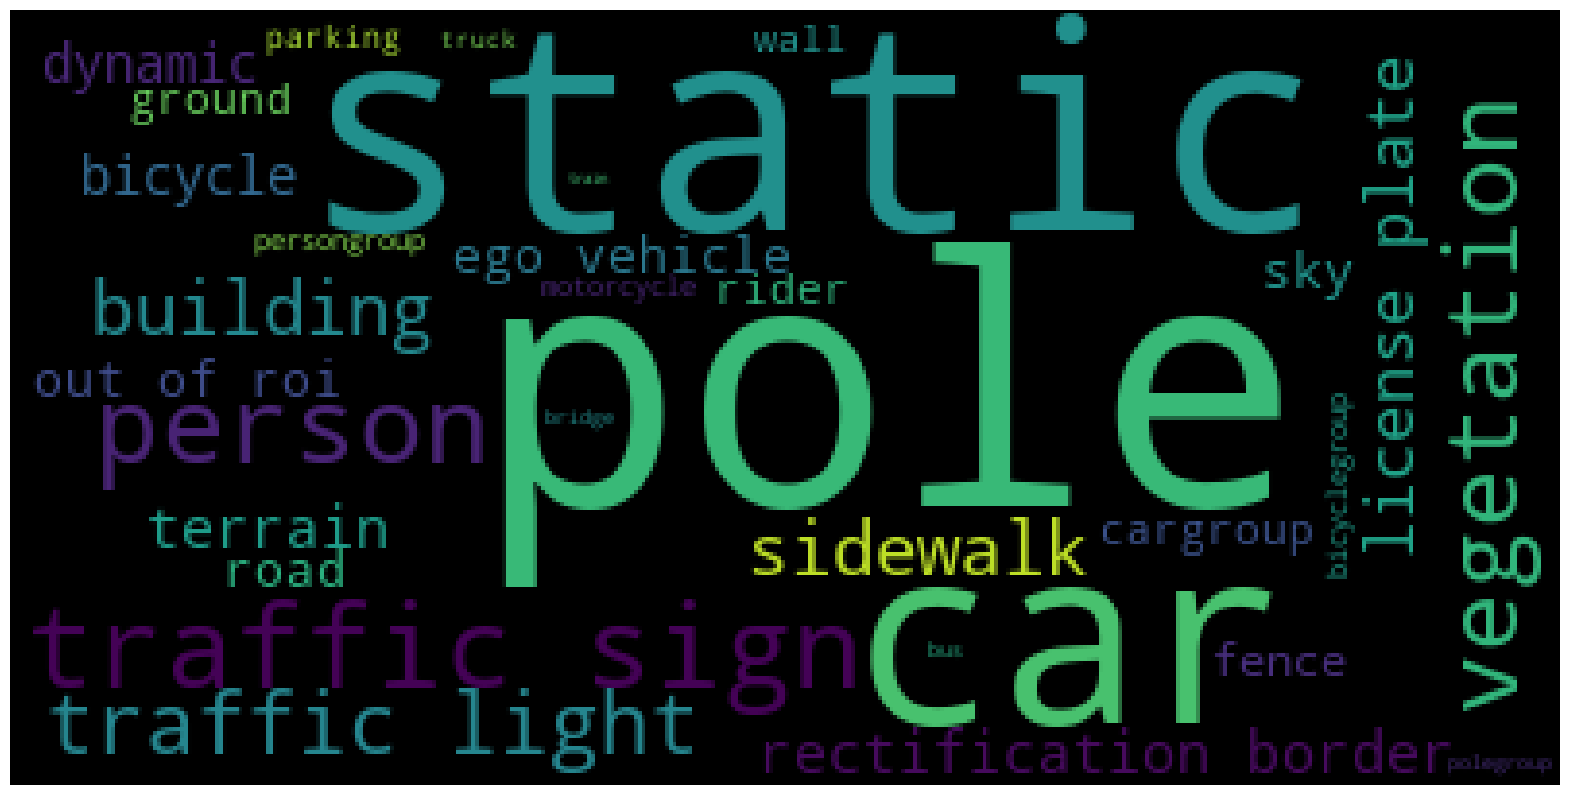

In [20]:
# Création de la liste des classes
classes_list = dataset_merged_df.labels.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par classe
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du Wordcloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

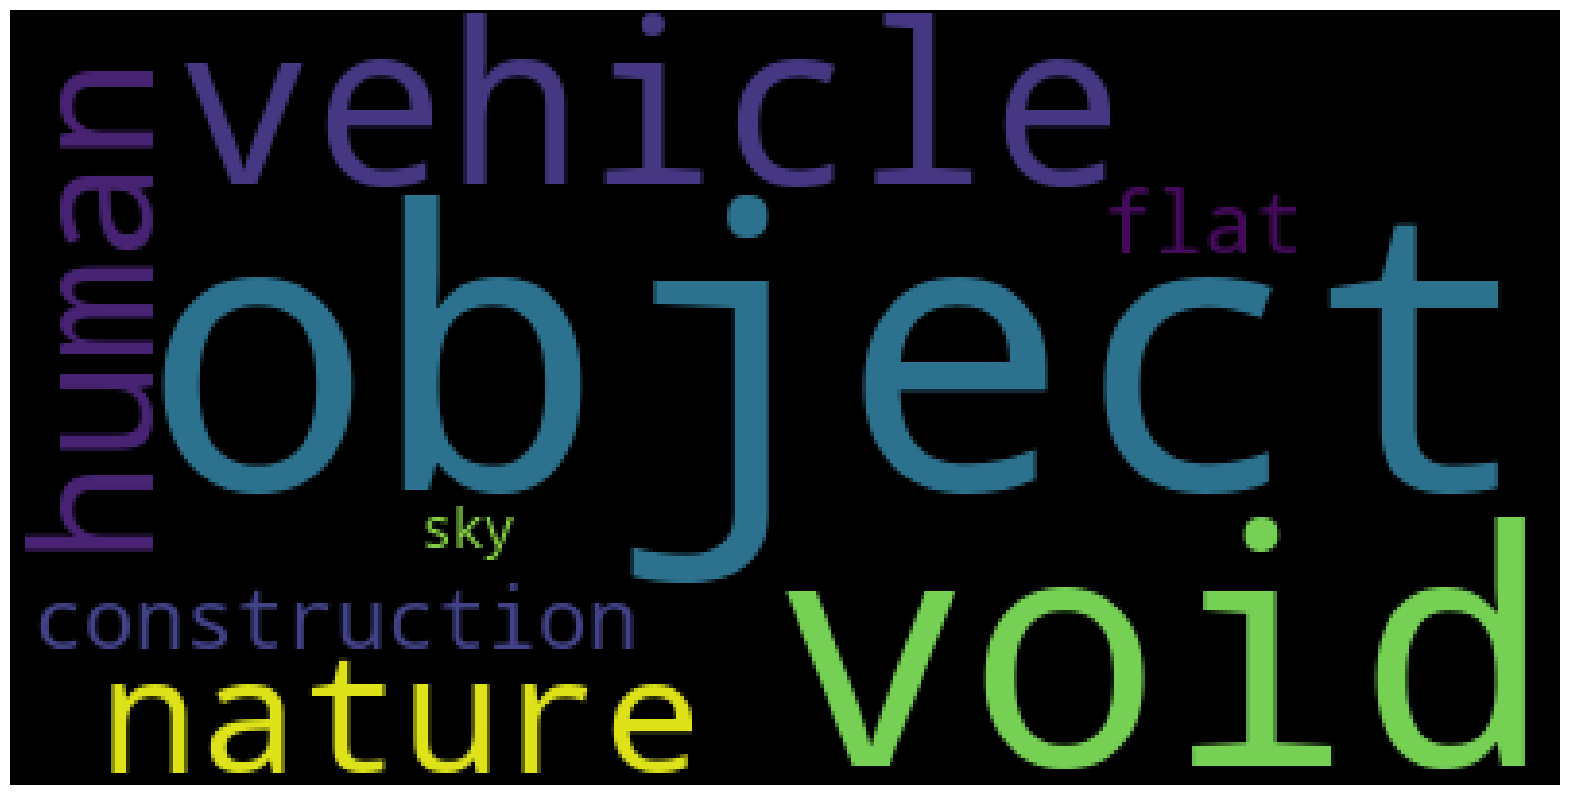

In [21]:
# Création de la liste des catégories
classes_list = dataset_merged_df.labels_main.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par catégorie
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du WordCloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

In [22]:
print("Les photos Train ont été prise dans {} villes différentes ".format(dataset_merged_df["city"].nunique()))

Les photos Train ont été prise dans 18 villes différentes 


In [23]:
print("Les villes concernées ", dataset_merged_df["city"].unique())

Les villes concernées  ['aachen' 'bochum' 'bremen' 'cologne' 'darmstadt' 'dusseldorf' 'erfurt'
 'hamburg' 'hanover' 'jena' 'krefeld' 'monchengladbach' 'strasbourg'
 'stuttgart' 'tubingen' 'ulm' 'weimar' 'zurich']


<Axes: title={'center': 'Distribution des images par ville'}, ylabel='proportion'>

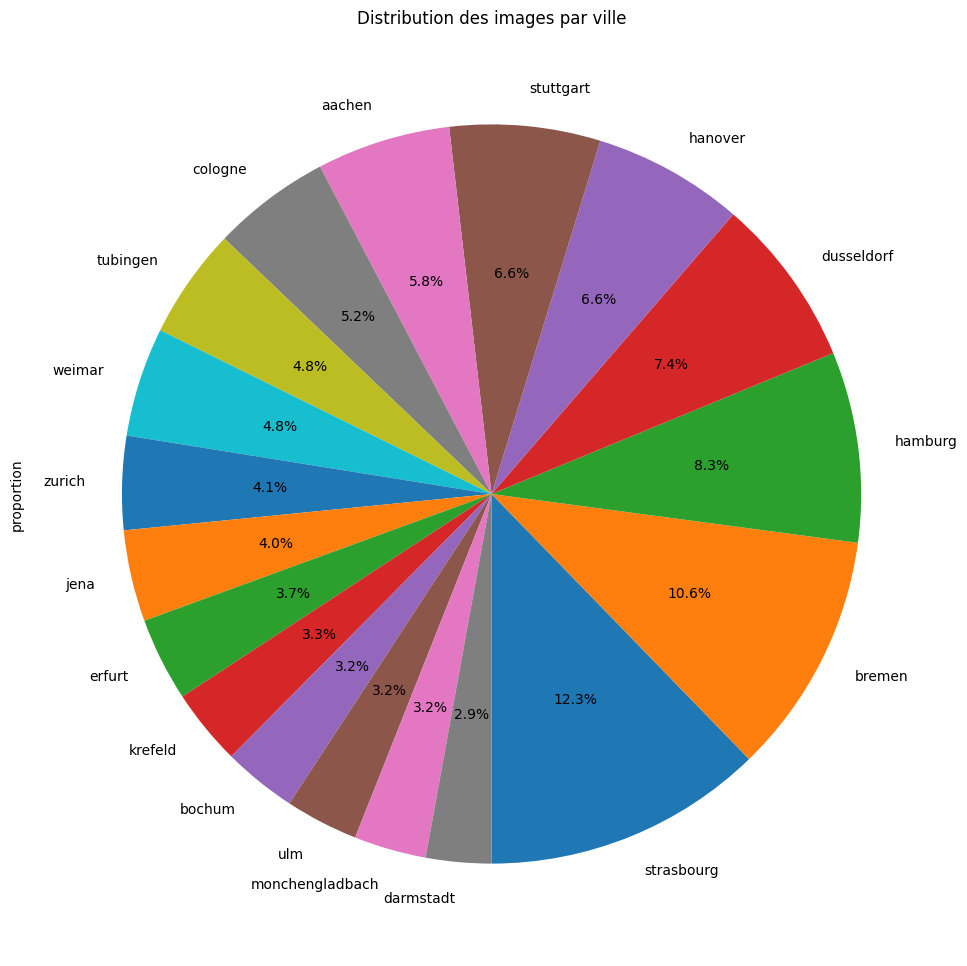

In [24]:
dataset_merged_df["city"].value_counts(normalize=True).plot(kind="pie", 
                                                            shadow=False, 
                                                            figsize=(15, 12), 
                                                            autopct='%1.1f%%', 
                                                            startangle=270,
                                                             title="Distribution des images par ville")

In [25]:
labels_all_df = dataset_merged_df.loc[:, "bicycle":"wall"]
#labels_all_df.columns
print("Il y a {} classes ".format(len(labels_all_df.columns.tolist())))
print("Voici la liste des classes : {}".format(labels_all_df.columns.tolist()))

Il y a 40 classes 
Voici la liste des classes : ['bicycle', 'bicyclegroup', 'bridge', 'building', 'bus', 'car', 'caravan', 'cargroup', 'dynamic', 'ego vehicle', 'fence', 'ground', 'guard rail', 'license plate', 'motorcycle', 'motorcyclegroup', 'out of roi', 'parking', 'person', 'persongroup', 'pole', 'polegroup', 'rail track', 'rectification border', 'rider', 'ridergroup', 'road', 'sidewalk', 'sky_x', 'static', 'terrain', 'traffic light', 'traffic sign', 'trailer', 'train', 'truck', 'truckgroup', 'tunnel', 'vegetation', 'wall']


<Axes: >

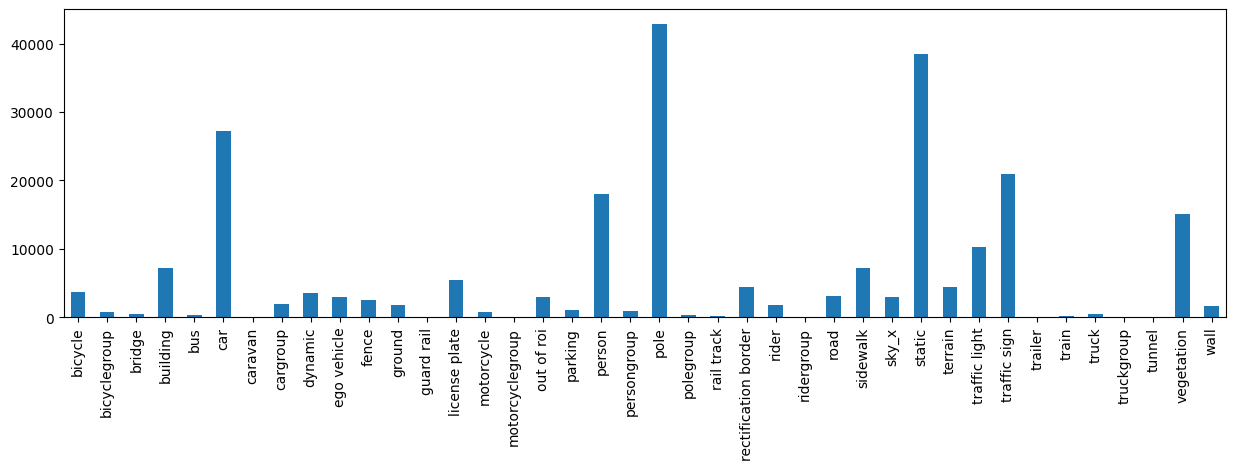

In [26]:
labels_all_df.sum().plot(kind="bar", 
                        figsize=(15, 4), 
                        )

<Axes: >

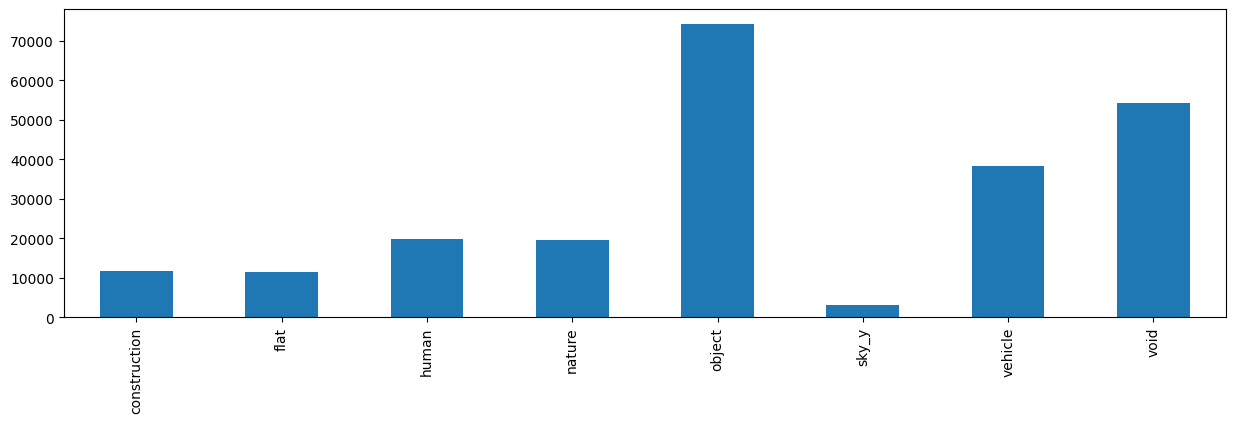

In [27]:
#Affichage par catégorie
labels_main_df = dataset_merged_df.loc[:, "construction":]

labels_main_df.sum().plot(kind="bar", 
                        figsize=(15, 4), 
                        )

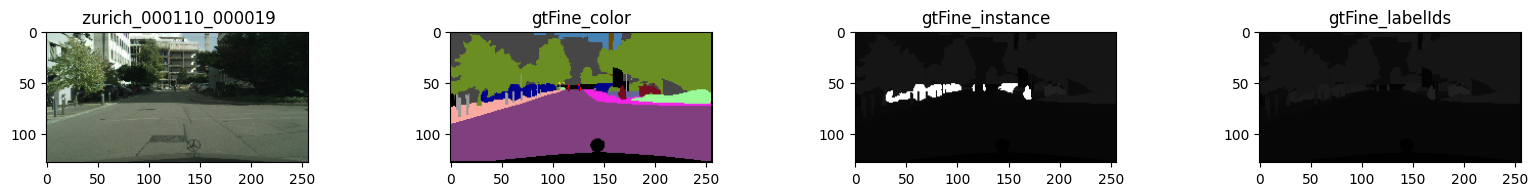

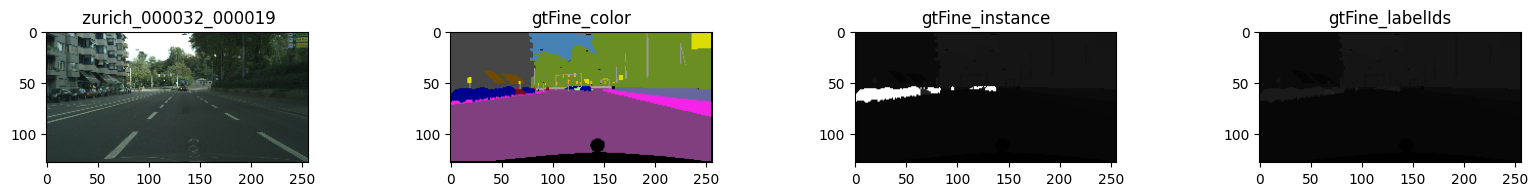

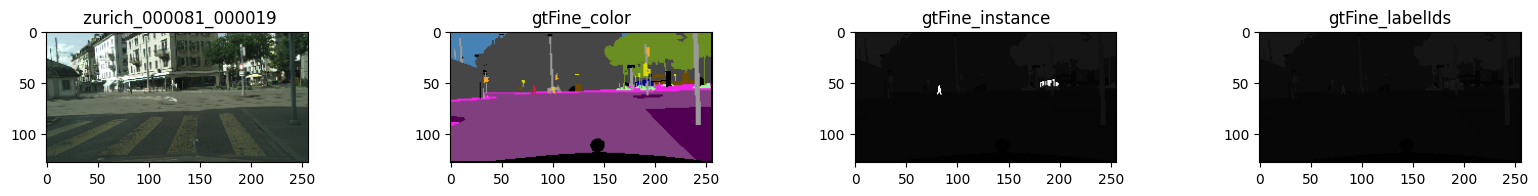

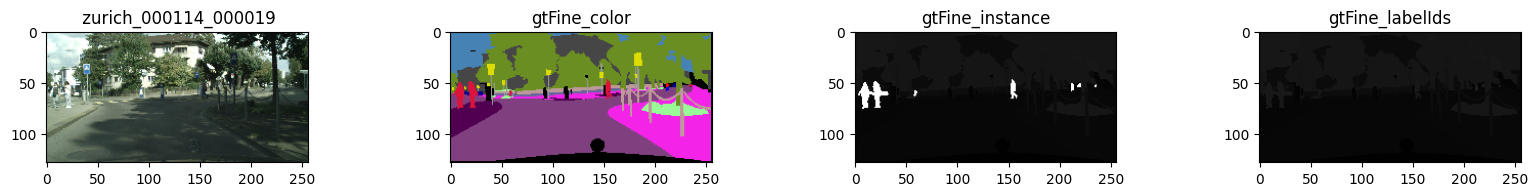

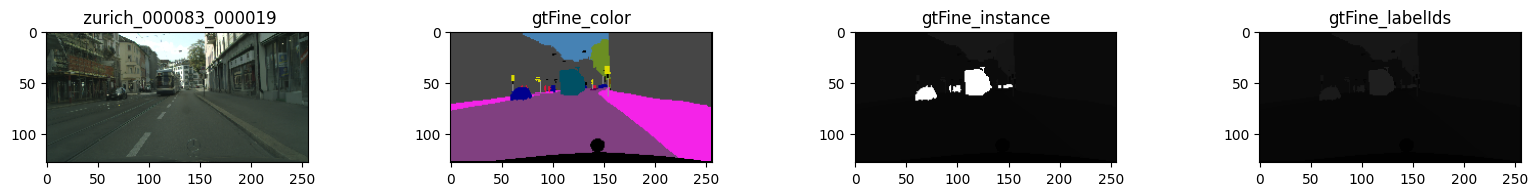

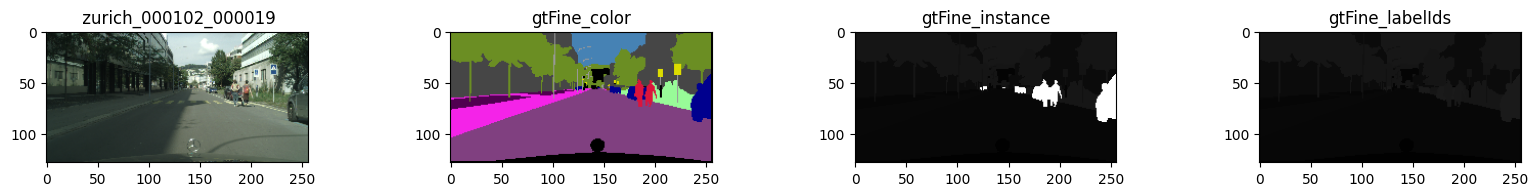

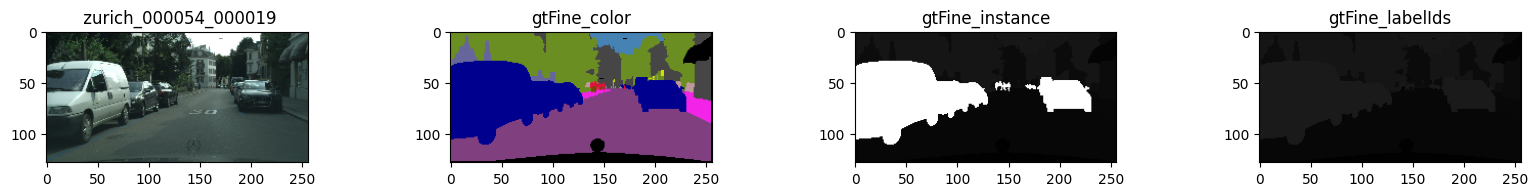

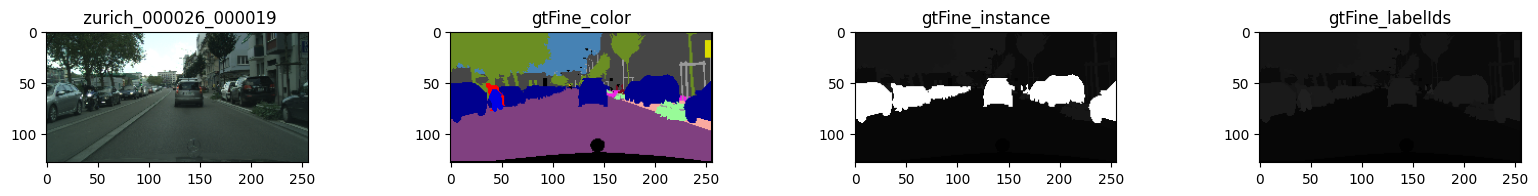

In [28]:
import random
NUMBER_IMAGES = 8
NCOL=4

# Prise en compte d'une ville au harsard
random_folder = random.choice(os.listdir(FOLDER_TRAINING_IMAGES))
folder_fullpath = os.path.join(FOLDER_TRAINING_IMAGES, random_folder)

# Choix d'une photo au hasard dans le dossier ville selectionné plus haut
images_choosen = random.choices(os.listdir(folder_fullpath), k=NUMBER_IMAGES)
for i, file in enumerate(images_choosen):
    basename = "_".join(file.split(".")[0].split("_")[:3])
    # Prise en compte du RGB color mask
    gt_color_file    = "{}_gtFine_color.png".format(basename)
    
    # Prise en compte du black and white instance mask
    gt_instance_file = "{}_gtFine_instanceIds.png".format(basename)
    
    # prise en compte du black and white labels mask
    gt_label_file = "{}_gtFine_labelIds.png".format(basename)
    
    # Enregistrement des chemins d'accès    
    file_full        = os.path.join(folder_fullpath, file)
    gt_color_full    = os.path.join(FOLDER_TRAINING_MASK, random_folder, gt_color_file)
    gt_instance_full = os.path.join(FOLDER_TRAINING_MASK, random_folder, gt_instance_file)
    gt_label_full    = os.path.join(FOLDER_TRAINING_MASK, random_folder, gt_label_file)
    
    # Chargement des images/masks   
    img_color     = tf.keras.preprocessing.image.load_img(file_full,target_size=(128,256))
    mask_color    = tf.keras.preprocessing.image.load_img(gt_color_full, target_size=(128,256))
    mask_instance = tf.keras.preprocessing.image.load_img(gt_instance_full, target_size=(128,256))
    mask_label    = tf.keras.preprocessing.image.load_img(gt_label_full, target_size=(128,256))
       
    #Affichage des images/masks
    plt.figure(figsize=(20, 18))
   
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+1)
    plt.title(" {}".format(basename))
    plt.imshow(np.asarray(img_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+2)
    plt.title("gtFine_color")
    plt.imshow(np.asarray(mask_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+3)
    plt.title("gtFine_instance")
    plt.imshow(np.asarray(mask_instance))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+4)
    plt.title("gtFine_labelIds")
    plt.imshow(np.asarray(mask_label))

plt.show()

## 4.2 Test

(-0.5, 399.5, 199.5, -0.5)

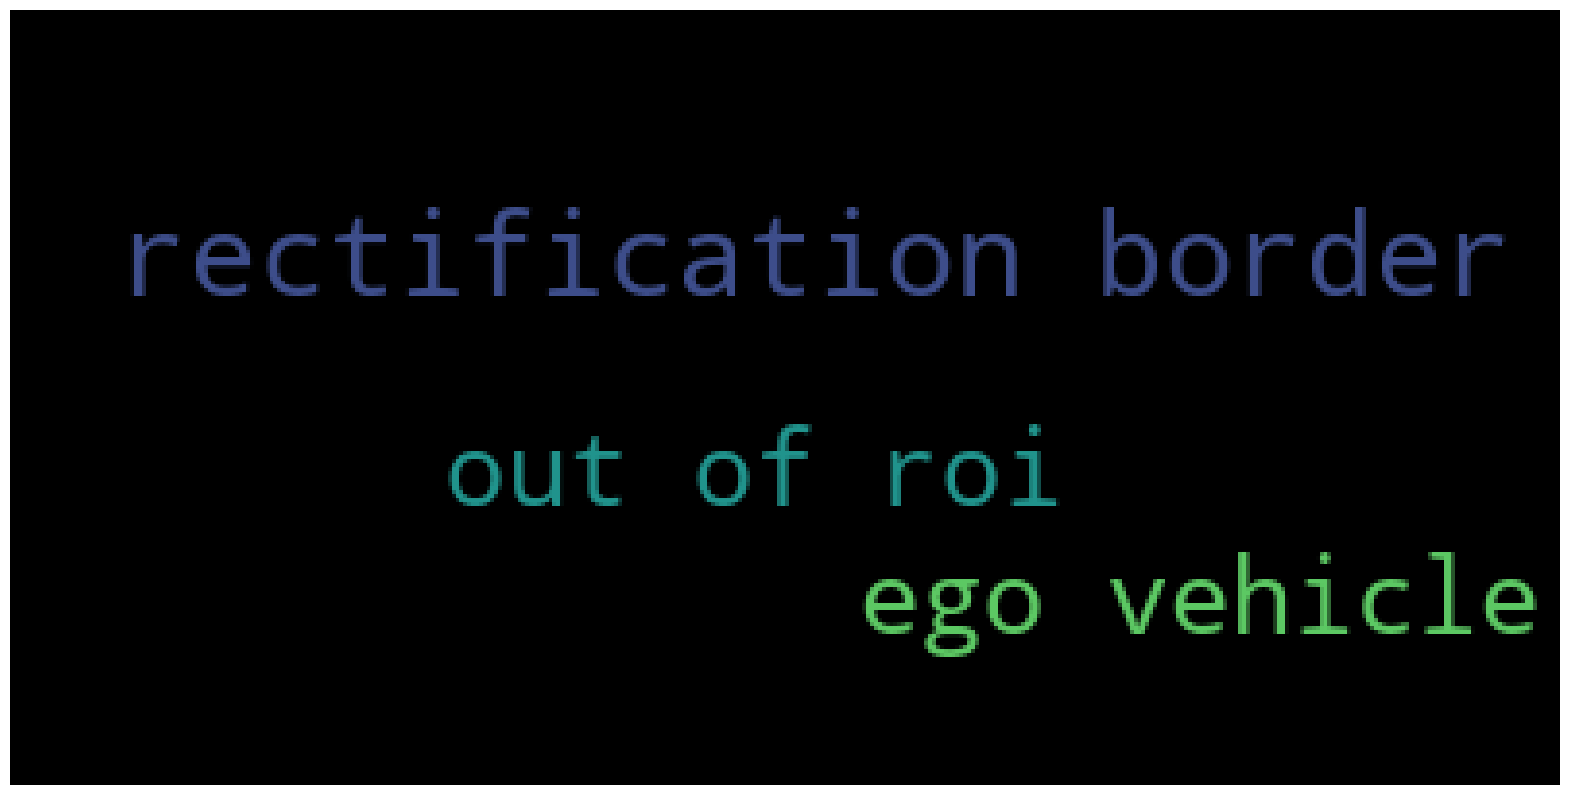

In [29]:
# Création de la liste des classes
classes_list = dataset_merged_df_test.labels.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par classe
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du Wordcloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

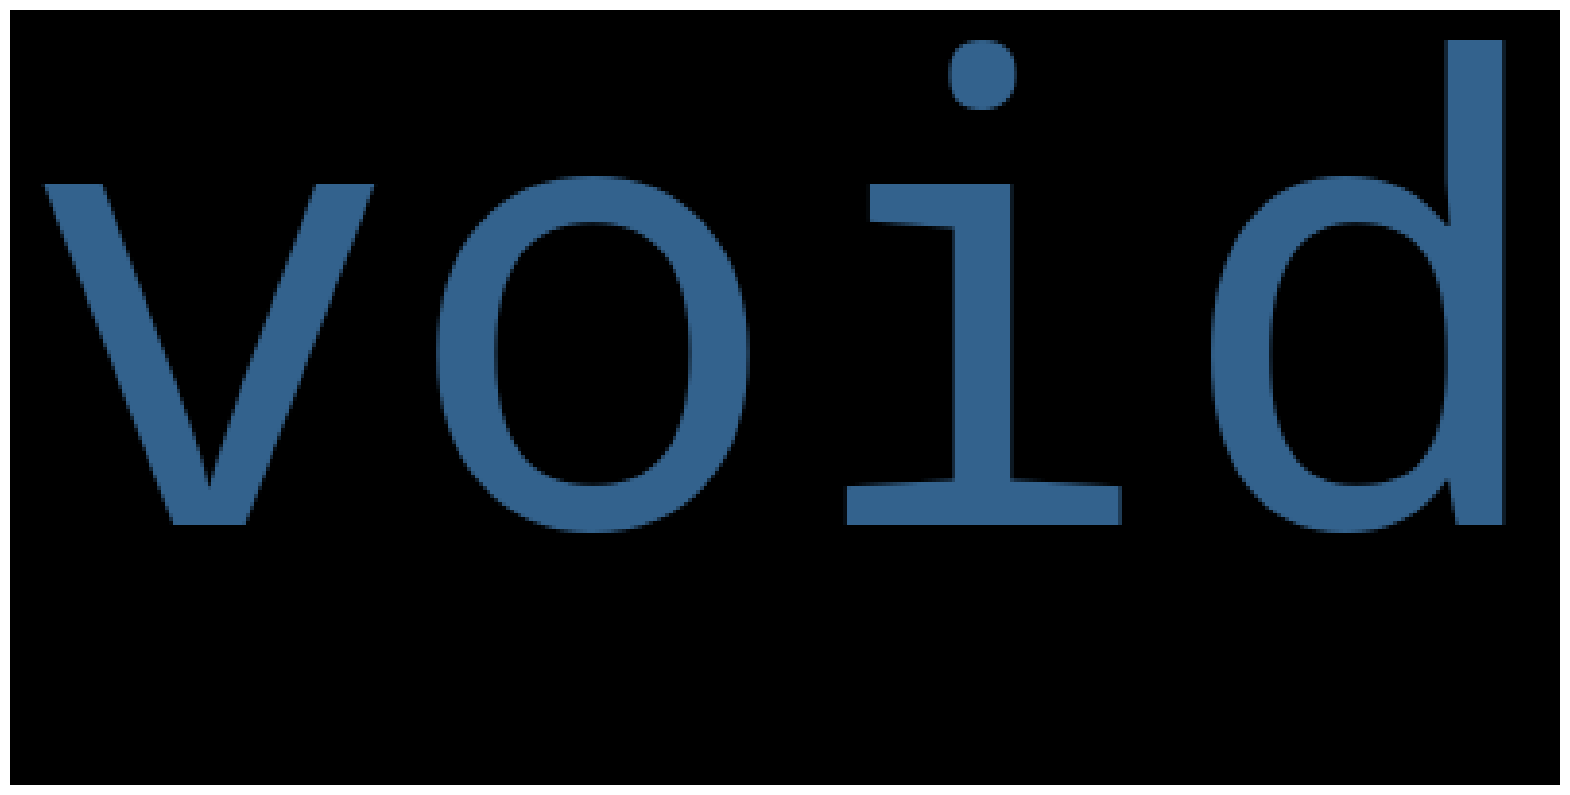

In [30]:
# Création de la liste des catégories
classes_list = dataset_merged_df_test.labels_main.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par catégorie
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du Wordcloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

In [31]:
print("Les photos Train ont été prise dans {} villes différentes".format(dataset_merged_df_test["city"].nunique()))

Les photos Train ont été prise dans 6 villes différentes


In [32]:
print("Voici les villes concernées: ", dataset_merged_df_test["city"].unique())

Voici les villes concernées:  ['berlin' 'bielefeld' 'bonn' 'leverkusen' 'mainz' 'munich']


<Axes: title={'center': 'Distribution des images par ville'}, ylabel='proportion'>

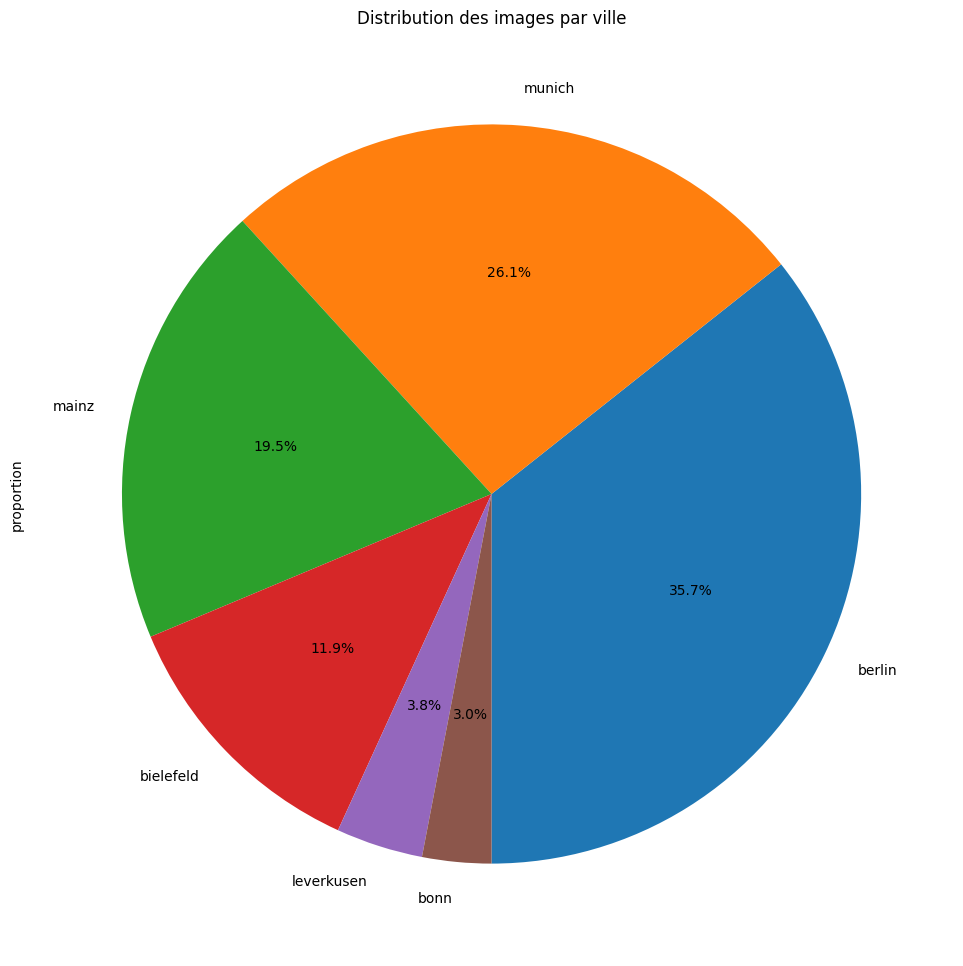

In [33]:
dataset_merged_df_test["city"].value_counts(normalize=True).plot(kind="pie", 
                                                            shadow=False, 
                                                            figsize=(15, 12), 
                                                            autopct='%1.1f%%', 
                                                            startangle=270,
                                                             title="Distribution des images par ville")

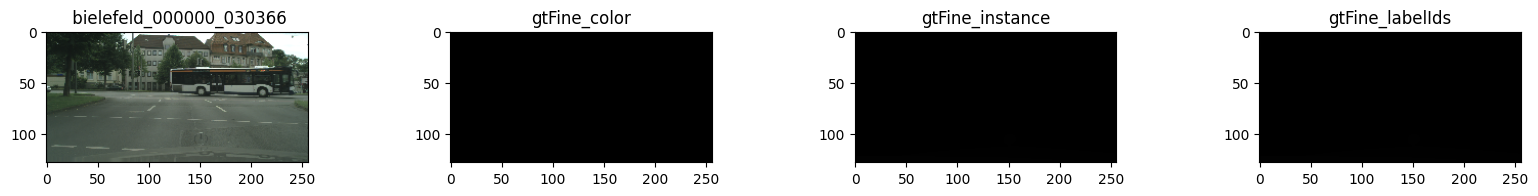

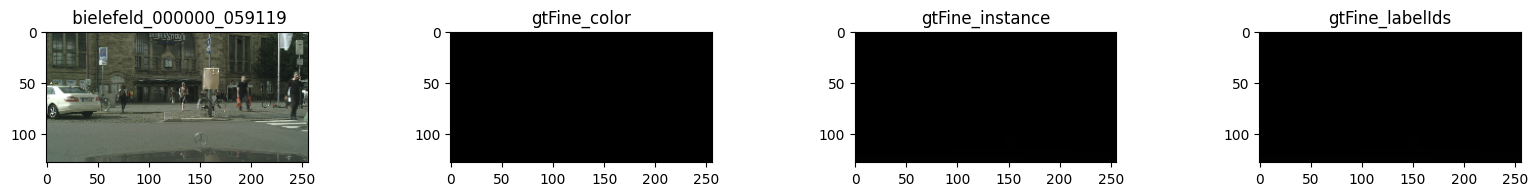

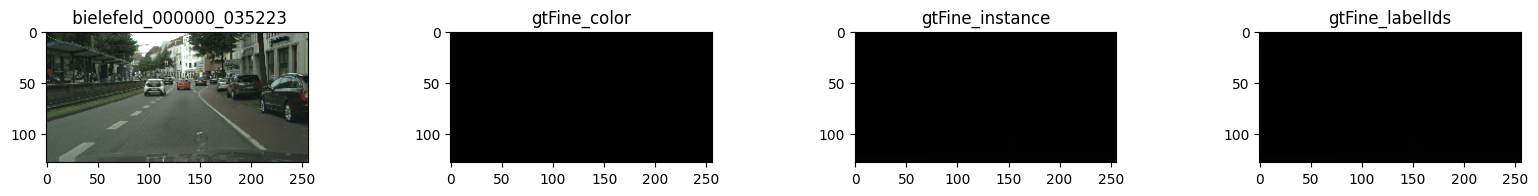

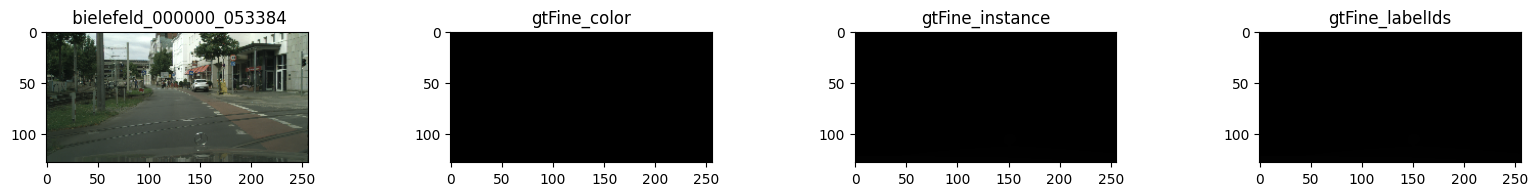

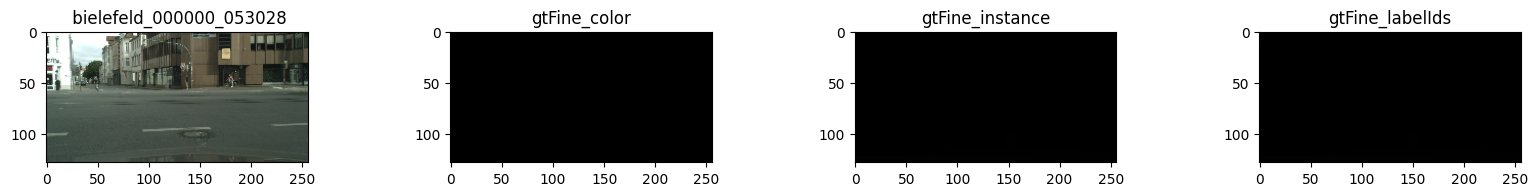

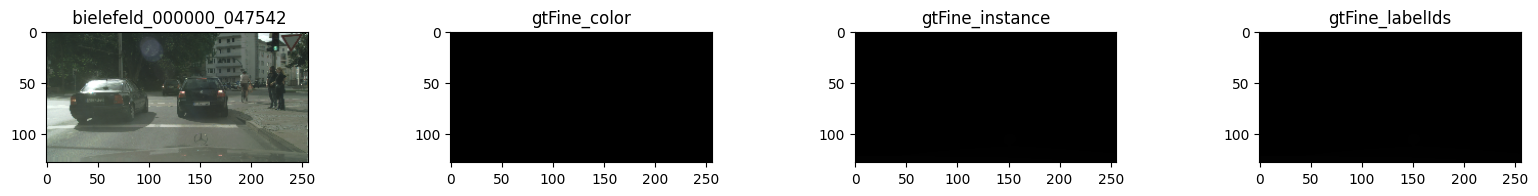

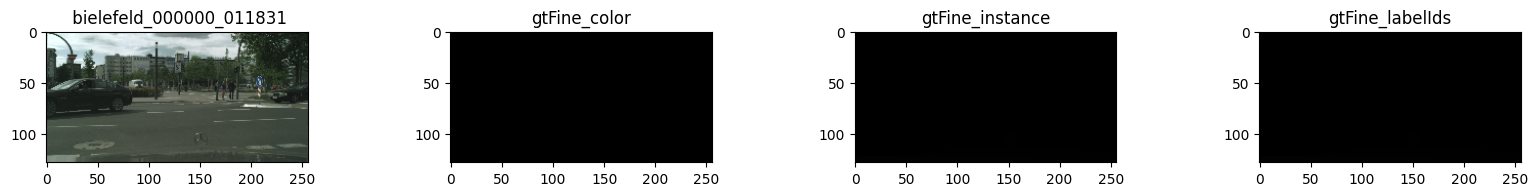

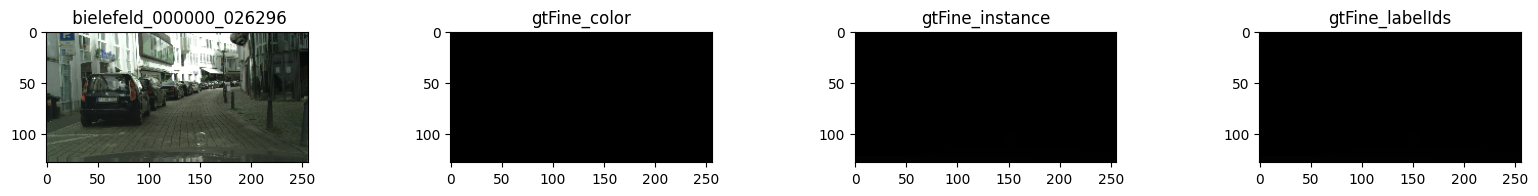

In [34]:
import random
NUMBER_IMAGES = 8
NCOL=4

# FOr the display, we choose a random folder
random_folder = random.choice(os.listdir(FOLDER_TEST_IMAGES))
folder_fullpath = os.path.join(FOLDER_TEST_IMAGES, random_folder)

# We choose a random file in the random folder
images_choosen = random.choices(os.listdir(folder_fullpath), k=NUMBER_IMAGES)
for i, file in enumerate(images_choosen):
    basename = "_".join(file.split(".")[0].split("_")[:3])
    # Get the RGB color mask
    gt_color_file    = "{}_gtFine_color.png".format(basename)
    
    # Get the black and white instance mask
    gt_instance_file = "{}_gtFine_instanceIds.png".format(basename)
    
    # Get the black and white labels mask
    gt_label_file = "{}_gtFine_labelIds.png".format(basename)
    
    # Get full absolute path for mask files    
    file_full        = os.path.join(folder_fullpath, file)
    gt_color_full    = os.path.join(FOLDER_TEST_MASK, random_folder, gt_color_file)
    gt_instance_full = os.path.join(FOLDER_TEST_MASK, random_folder, gt_instance_file)
    gt_label_full    = os.path.join(FOLDER_TEST_MASK, random_folder, gt_label_file)
    
    # Load masks images from masks files paths    
    img_color     = tf.keras.preprocessing.image.load_img(file_full,target_size=(128,256))
    mask_color    = tf.keras.preprocessing.image.load_img(gt_color_full, target_size=(128,256))
    mask_instance = tf.keras.preprocessing.image.load_img(gt_instance_full, target_size=(128,256))
    mask_label    = tf.keras.preprocessing.image.load_img(gt_label_full, target_size=(128,256))
       
    #Plot the mask images
    plt.figure(figsize=(20, 18))
   
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+1)
    plt.title(" {}".format(basename))
    plt.imshow(np.asarray(img_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+2)
    plt.title("gtFine_color")
    plt.imshow(np.asarray(mask_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+3)
    plt.title("gtFine_instance")
    plt.imshow(np.asarray(mask_instance))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+4)
    plt.title("gtFine_labelIds")
    plt.imshow(np.asarray(mask_label))

plt.show()

## 4.3 Val

(-0.5, 399.5, 199.5, -0.5)

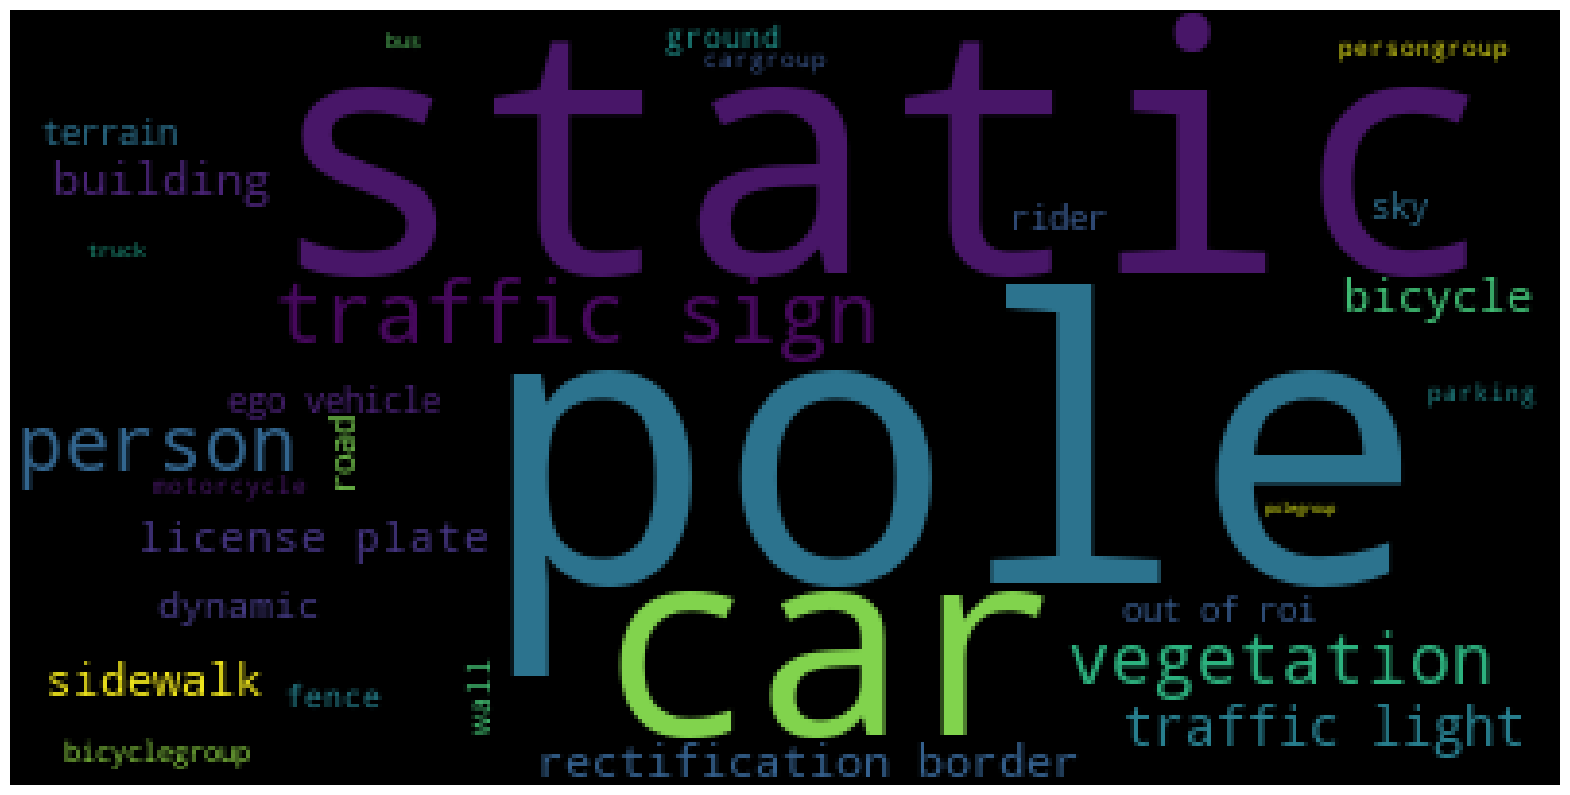

In [35]:
# Création de la liste des classes
classes_list = dataset_merged_df_val.labels.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par classe
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du Wordcloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

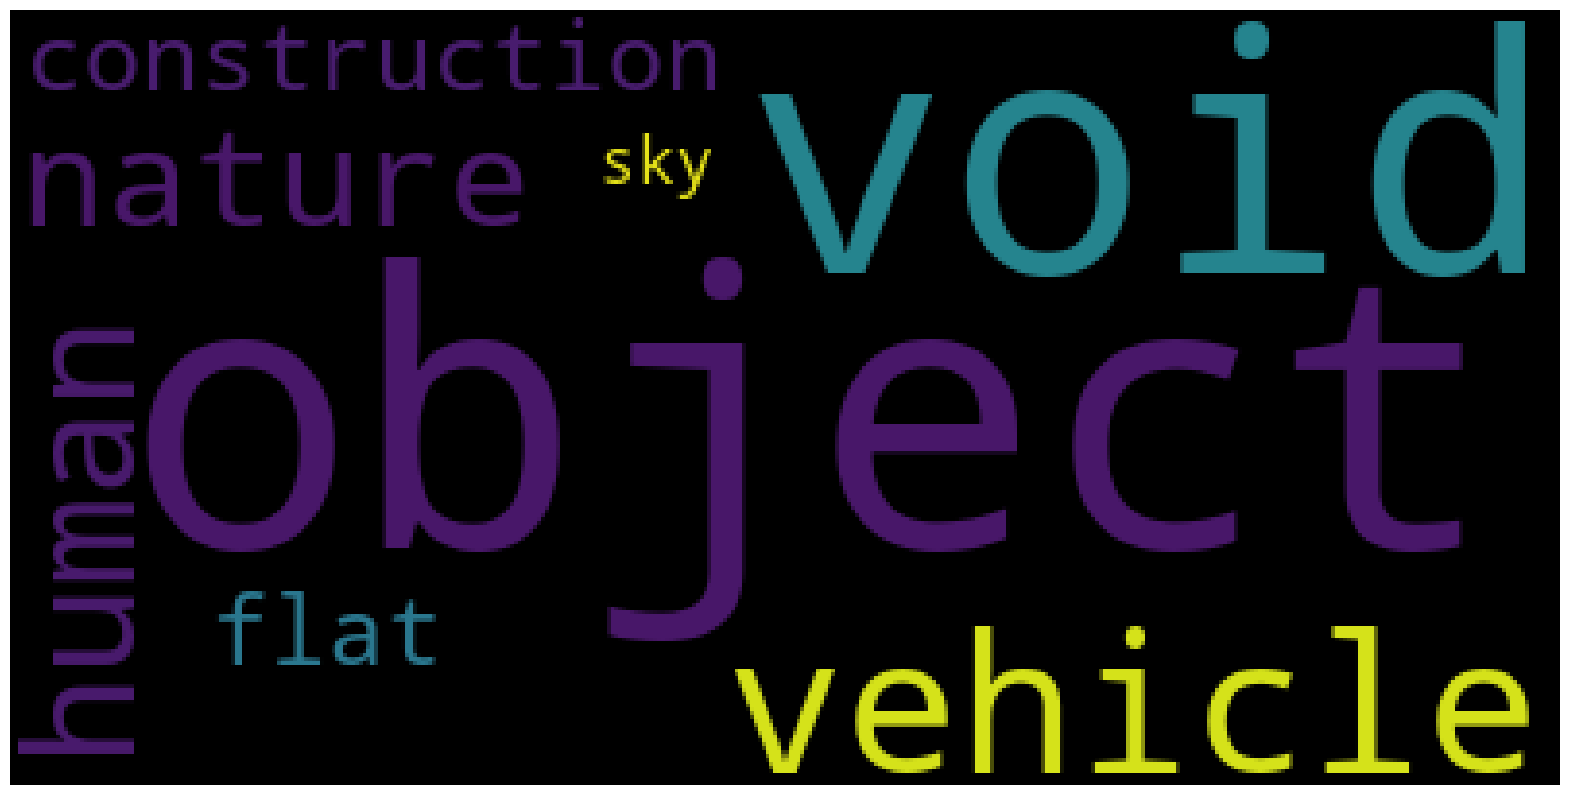

In [36]:
# Création de la liste des catégories
classes_list = dataset_merged_df_val.labels_main.tolist()
classes_list = [item for sublist in classes_list for item in sublist]

# Calcul du nombre d'élements par catégorie
classes_frequencies = dict(Counter(classes_list))
wordcloud = WordCloud().generate_from_frequencies(classes_frequencies)

# Affichage du Wordcloud
plt.figure(figsize=(20, 15))
plt.imshow(wordcloud)
plt.axis("off")

In [37]:
print("Les photos Train ont été prise dans {} villes différentes".format(dataset_merged_df_val["city"].nunique()))

Les photos Train ont été prise dans 3 villes différentes


In [38]:
print("Voici les villes concernées", dataset_merged_df_val["city"].unique())

Voici les villes concernées ['frankfurt' 'lindau' 'munster']


<Axes: title={'center': 'Distribution des images par ville'}, ylabel='proportion'>

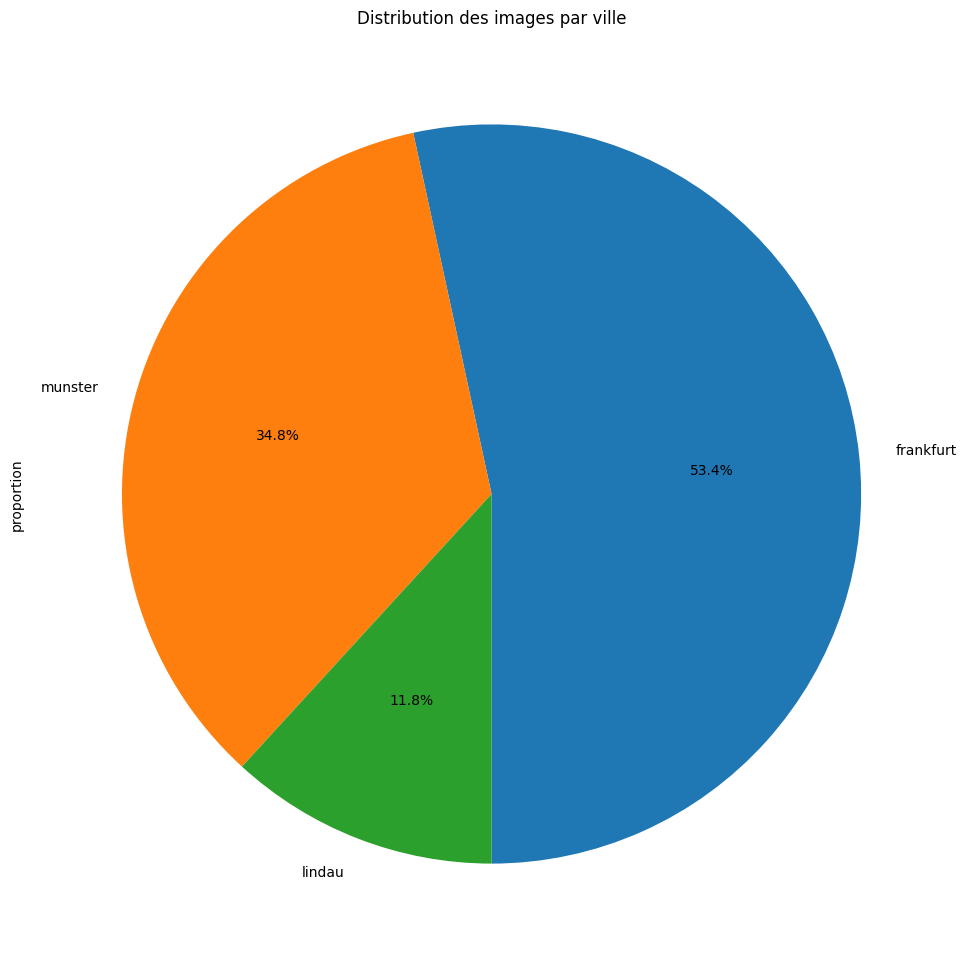

In [39]:
dataset_merged_df_val["city"].value_counts(normalize=True).plot(kind="pie", 
                                                            shadow=False, 
                                                            figsize=(15, 12), 
                                                            autopct='%1.1f%%', 
                                                            startangle=270,
                                                             title="Distribution des images par ville")

In [40]:
labels_all_df_val = dataset_merged_df_val.loc[:, "bicycle":"wall"]
#labels_all_df.columns
print("Il y a  {} classes ".format(len(labels_all_df.columns.tolist())))
print("Voici la liste des classes : {}".format(labels_all_df.columns.tolist()))

Il y a  40 classes 
Voici la liste des classes : ['bicycle', 'bicyclegroup', 'bridge', 'building', 'bus', 'car', 'caravan', 'cargroup', 'dynamic', 'ego vehicle', 'fence', 'ground', 'guard rail', 'license plate', 'motorcycle', 'motorcyclegroup', 'out of roi', 'parking', 'person', 'persongroup', 'pole', 'polegroup', 'rail track', 'rectification border', 'rider', 'ridergroup', 'road', 'sidewalk', 'sky_x', 'static', 'terrain', 'traffic light', 'traffic sign', 'trailer', 'train', 'truck', 'truckgroup', 'tunnel', 'vegetation', 'wall']


<Axes: >

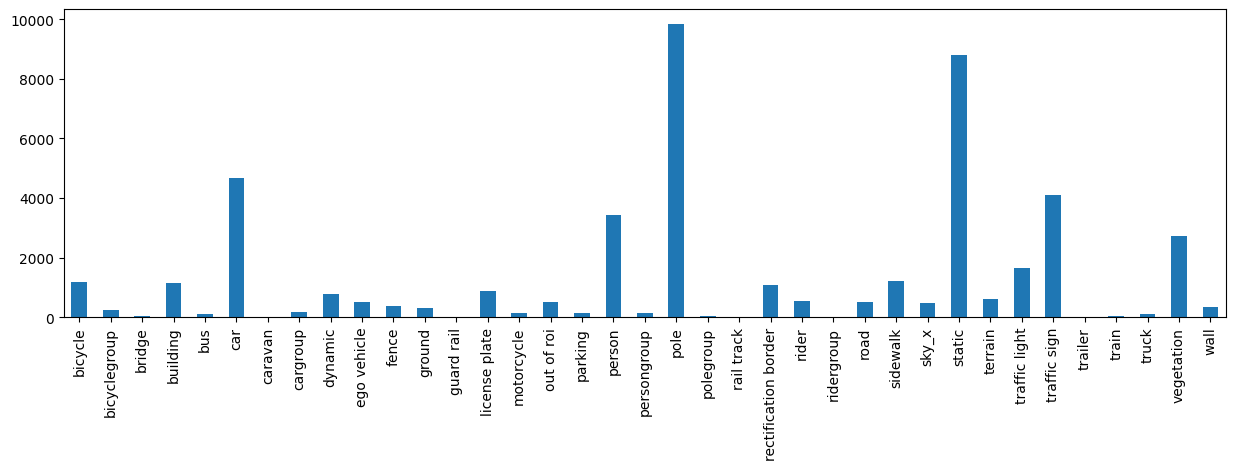

In [41]:
labels_all_df_val.sum().plot(kind="bar", 
                        figsize=(15, 4), 
                        )

<Axes: >

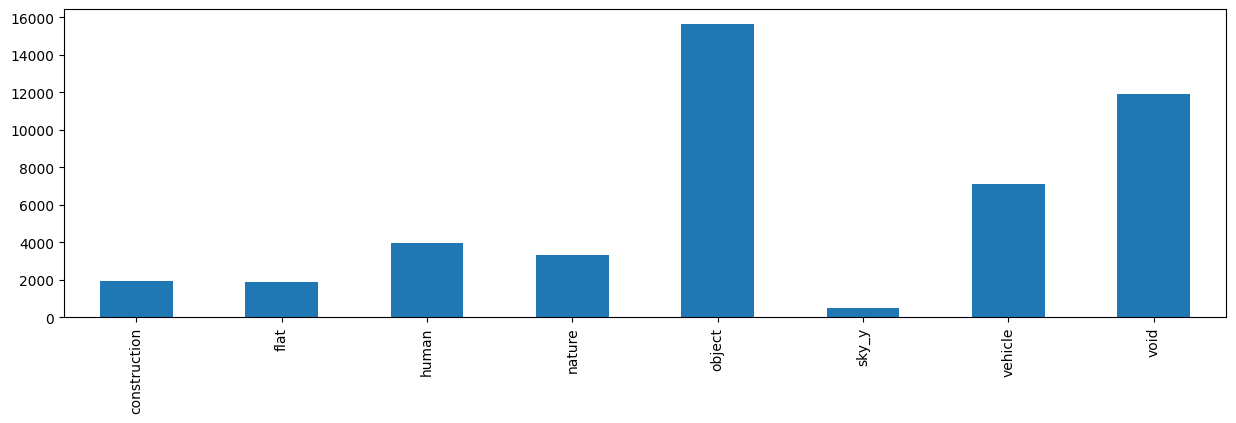

In [42]:
labels_main_df_val = dataset_merged_df_val.loc[:, "construction":]

labels_main_df_val.sum().plot(kind="bar", 
                        figsize=(15, 4), 
                        )

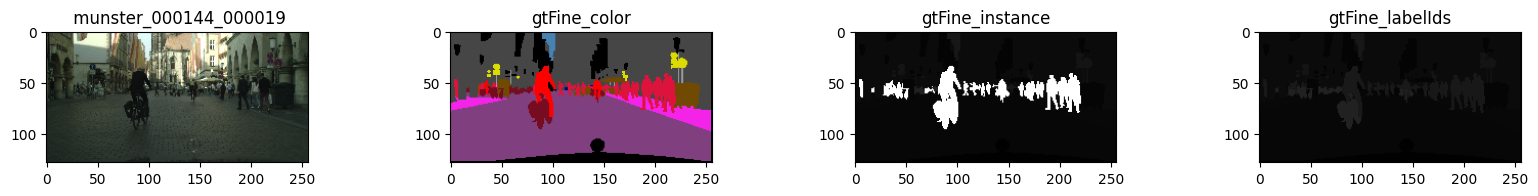

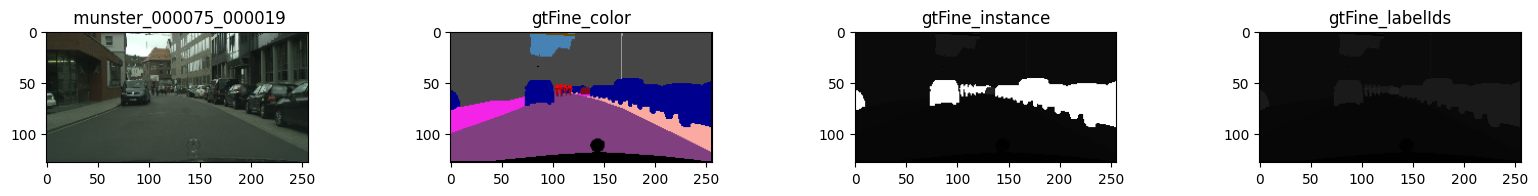

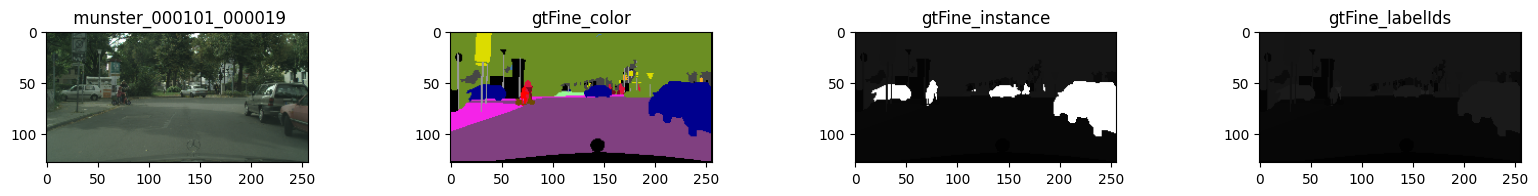

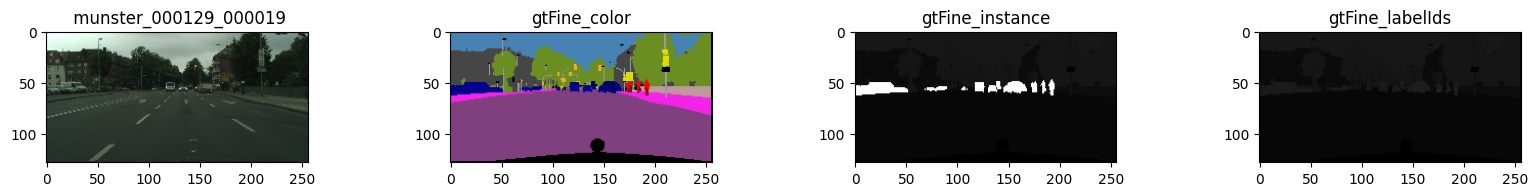

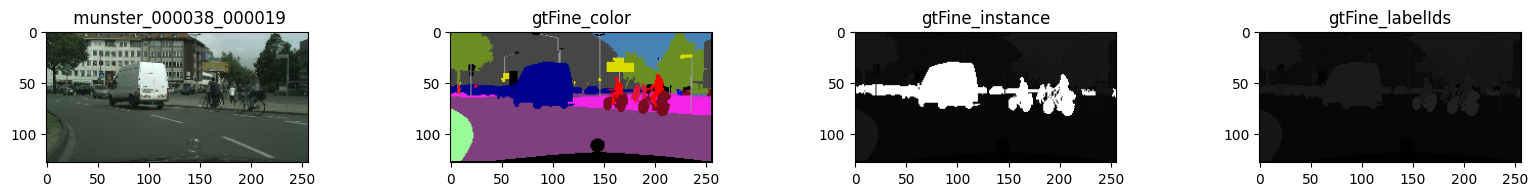

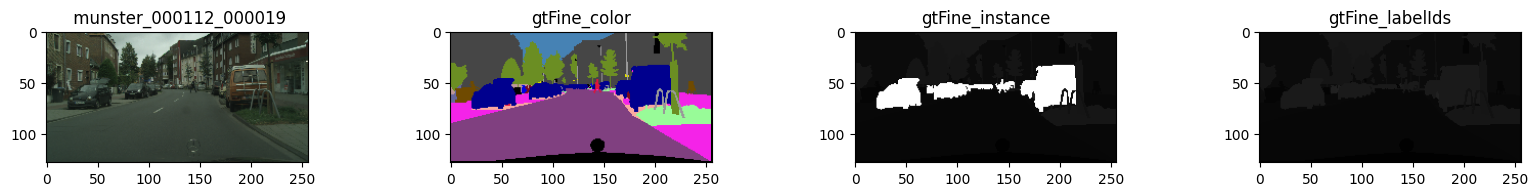

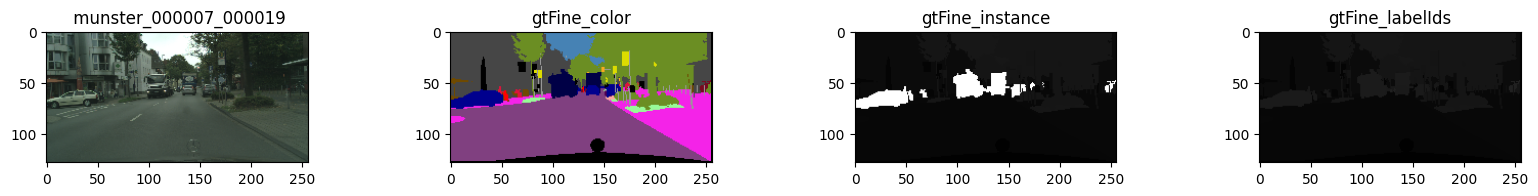

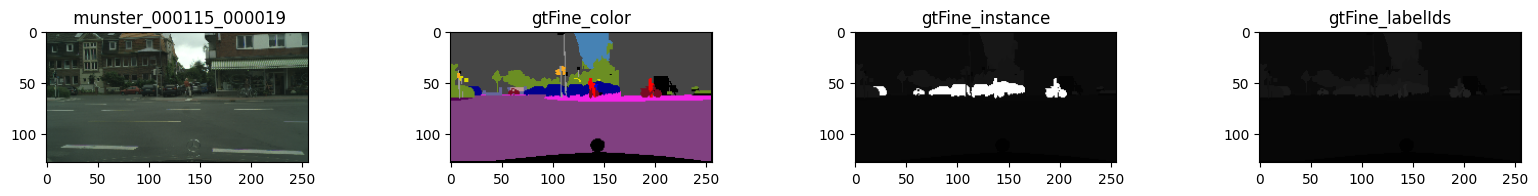

In [43]:
import random
NUMBER_IMAGES = 8
NCOL=4

# Prise en compte d'une ville au harsard
random_folder = random.choice(os.listdir(FOLDER_VALIDATION_IMAGES))
folder_fullpath = os.path.join(FOLDER_VALIDATION_IMAGES, random_folder)

# Choix d'une photo au hasard dans le dossier ville selectionné plus haut
images_choosen = random.choices(os.listdir(folder_fullpath), k=NUMBER_IMAGES)
for i, file in enumerate(images_choosen):
    basename = "_".join(file.split(".")[0].split("_")[:3])
    # Prise en compte du RGB color mask
    gt_color_file    = "{}_gtFine_color.png".format(basename)
    
    # Prise en compte du black and white instance mask
    gt_instance_file = "{}_gtFine_instanceIds.png".format(basename)
    
    # Prise en compte du black and white labels mask
    gt_label_file = "{}_gtFine_labelIds.png".format(basename)
    
    # Enregistrement des chemins d'accès    
    file_full        = os.path.join(folder_fullpath, file)
    gt_color_full    = os.path.join(FOLDER_VALIDATION_MASK, random_folder, gt_color_file)
    gt_instance_full = os.path.join(FOLDER_VALIDATION_MASK, random_folder, gt_instance_file)
    gt_label_full    = os.path.join(FOLDER_VALIDATION_MASK, random_folder, gt_label_file)
    
    # Chargement des images/masks   
    img_color     = tf.keras.preprocessing.image.load_img(file_full,target_size=(128,256))
    mask_color    = tf.keras.preprocessing.image.load_img(gt_color_full, target_size=(128,256))
    mask_instance = tf.keras.preprocessing.image.load_img(gt_instance_full, target_size=(128,256))
    mask_label    = tf.keras.preprocessing.image.load_img(gt_label_full, target_size=(128,256))
       
    # Affichage des images/masks
    plt.figure(figsize=(20, 18))
   
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+1)
    plt.title(" {}".format(basename))
    plt.imshow(np.asarray(img_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+2)
    plt.title("gtFine_color")
    plt.imshow(np.asarray(mask_color))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+3)
    plt.title("gtFine_instance")
    plt.imshow(np.asarray(mask_instance))
    
    plt.subplot((NUMBER_IMAGES*4//NCOL)+1, NCOL, (i*NCOL)+4)
    plt.title("gtFine_labelIds")
    plt.imshow(np.asarray(mask_label))

plt.show()

In [44]:
#STOP

# <a name="C5">5. Préparation des données<a>

## <a name="C51">5.1 Segmentation<a>

In [45]:
# Fonction qui sert à extraire la matrice de segmentation masque 

def get_numpy_mask_from_image(mask_img):
    mask_array   = np.zeros((mask_img.shape[0], mask_img.shape[1], 8),dtype=int) # Création d'un masque qu'avec des 0

    for k, v in category2labels.items():
        #print("[INFO] : Processing for main category ", k)
        for category_label in v: 
            categoryId = category_label[4]
            labelID = category_label[1]
            #print("    [INFO] : Processing for subcategory {} (labelID = {} | categoryId={})".format(category_label[0], labelID, categoryId))
            mask_array[:,:,categoryId] = np.logical_or(mask_array[:,:,categoryId],(mask_img==labelID))
    
    return mask_array

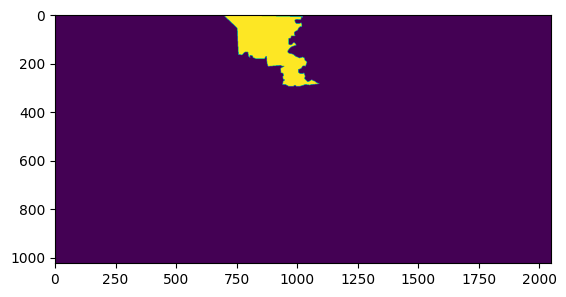

In [46]:
# Test de la fonction sur une image choisie (LabelIds)
mask_file = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/monchengladbach/monchengladbach_000000_007851_gtFine_labelIds.png"

# Enregistrement du format RGB array du masque en utilisant OpenCV
mask_array = cv2.cvtColor(cv2.imread(mask_file), cv2.COLOR_BGR2GRAY)

# Enregistrement de la matrice de segmentation
mask = get_numpy_mask_from_image(mask_img = mask_array)

# La segmentation correspond à une matrice en 8 dimensions (impossible de la voire entière pour l'oeil humain) 
# Affichons la dimension n°5 = sky (voir variable id2category)

plt.imshow(mask[:,:,5])
plt.show()


Image choisie :  input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train\dusseldorf\dusseldorf_000088_000019_leftImg8bit.png
Masque correspondant :  input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train\dusseldorf\dusseldorf_000088_000019_gtFine_labelIds.png


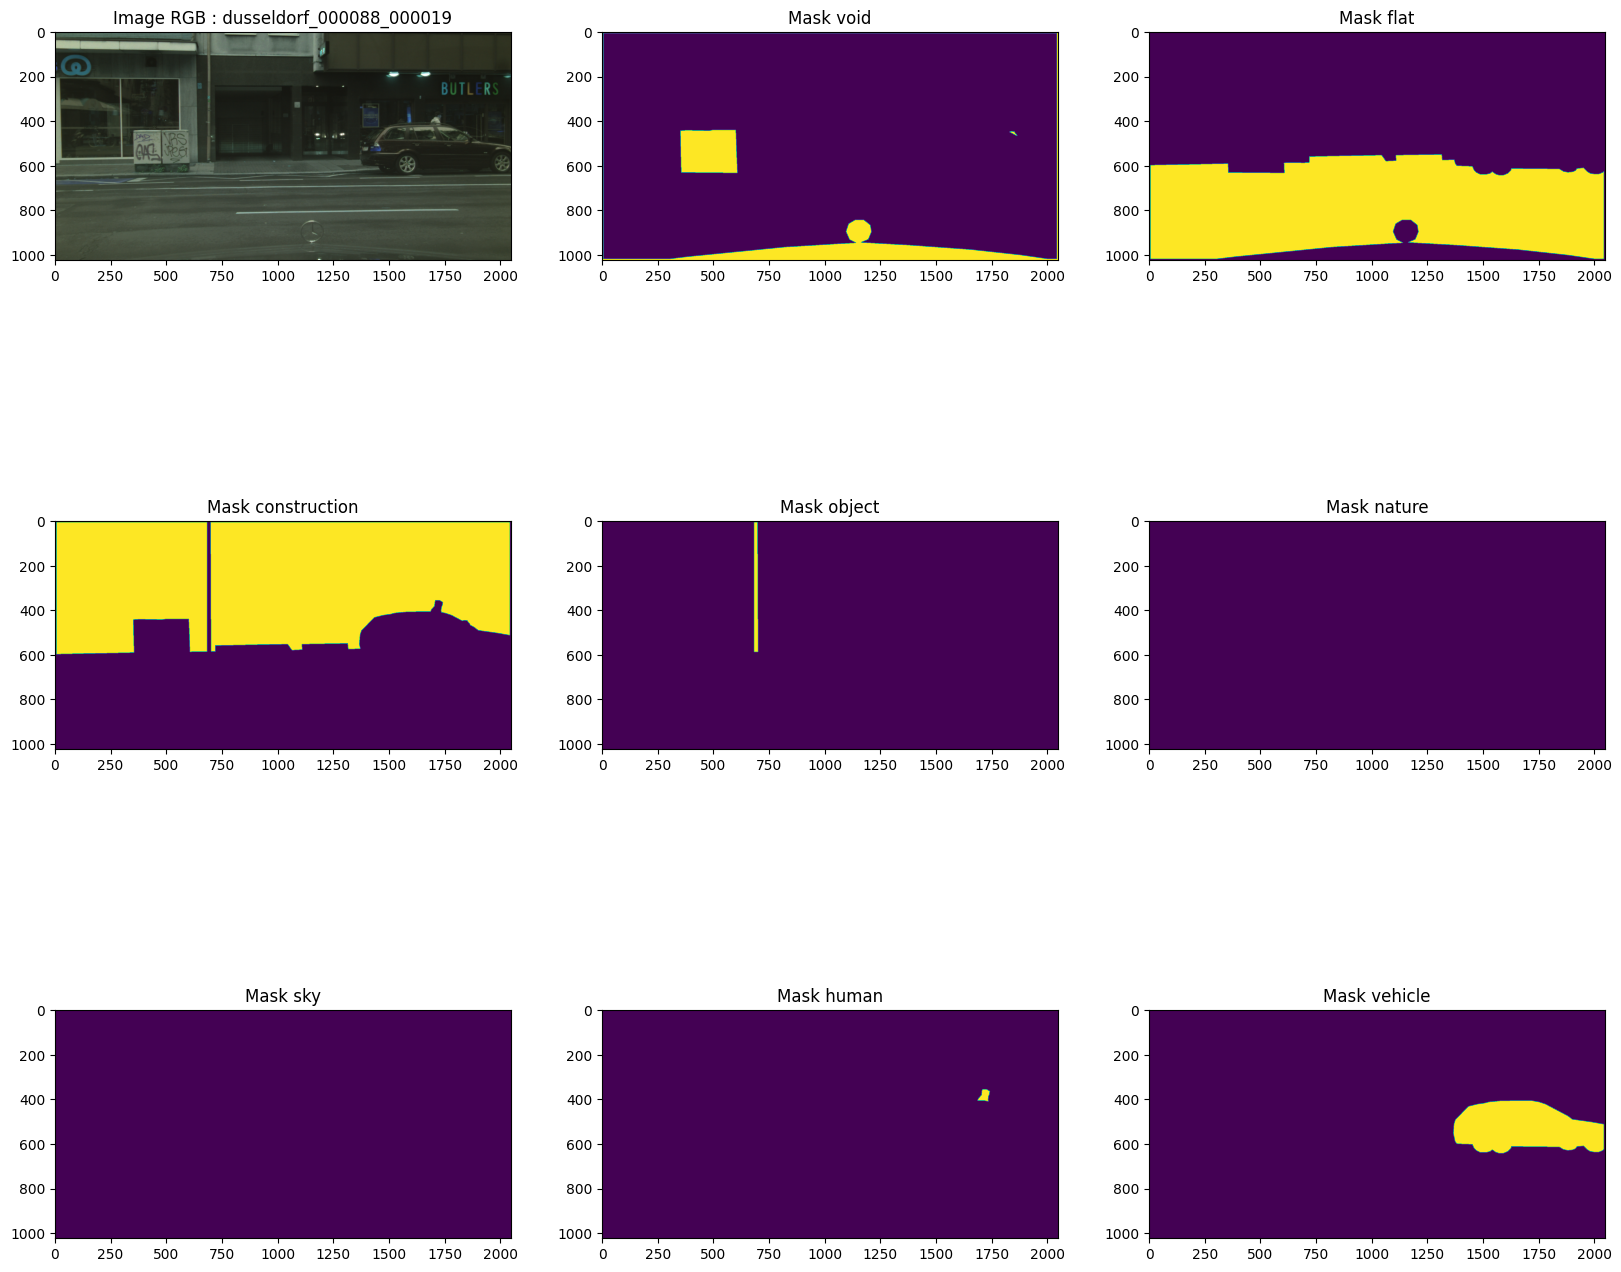

In [47]:
# Affichons une image au hasard ainsi que ses 8 masques associés pour vérifier la cohérence des masques associés

NCOL=3

# Prise en compte d'une ville au hasard dans le training dataset
random_folder = random.choice(os.listdir(FOLDER_TRAINING_IMAGES))
folder_fullpath = os.path.join(FOLDER_TRAINING_IMAGES, random_folder)

# Prise en compte d'une image au hasard dans la ville selectionnée au desus
image_choosen = random.choice(os.listdir(folder_fullpath))
basename = "_".join(image_choosen.split(".")[0].split("_")[:3])
file_full     = os.path.join(folder_fullpath, image_choosen)
print("Image choisie : ", file_full)

# Enregistrement du masque de segmentation "label" correspondant à la photo 
gt_label_file = "{}_gtFine_labelIds.png".format(basename)
gt_label_full = os.path.join(FOLDER_TRAINING_MASK, random_folder, gt_label_file)
print("Masque correspondant : ", gt_label_full)

# Enregistrement du format RGB array du masque en utilisant OpenCV
mask_array    = cv2.cvtColor(cv2.imread(gt_label_full), cv2.COLOR_BGR2GRAY)

# Enregistrement de la matrice de segmentation
mask          = get_numpy_mask_from_image(mask_img = mask_array)

# Affichage des images
plt.figure(figsize=(20, 18))

for j in range(9):
    if j == 0:
        plt.subplot(3, NCOL, j+1)
        plt.imshow(cv2.imread(file_full))
        plt.title("Image RGB : {}".format(basename))
    else:
        plt.subplot(3, NCOL, j+1)
        #plt.imshow(1-mask[:,:,j-1], cmap="Greys", interpolation='nearest')
        plt.imshow(mask[:,:,j-1])

        plt.title("Mask {}".format(id2category[j-1]))
    
plt.show()

## <a name="C52">5.2 Augmentation<a>

In [48]:
# Fonction pour de l'augmentation géométrique 
def load_augmentation_aug_geometric():
    # "OneOf" permet d'effectuer une augmentation parmis celles listées ci-dessous
    
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.2), iaa.Flipud(0)]),
        iaa.CropAndPad(percent=(-0.1, 0.1), pad_mode='constant', pad_cval=(0, 255)),
        iaa.Crop(percent=(0.0, 0.3)),
        iaa.Crop(percent=(0.1, 0.5)),
        iaa.Crop(percent=(0.2, 0.4)),
        iaa.Crop(percent=(0.0, 0.25)),
        iaa.Sequential([
        iaa.Affine(
                # Changement d'échalle de l'image de 80-120% de la taille d'origine - chaque axe est traité indépendemment
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # Translation de -20 to +20 % par axe
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                rotate=(-45, 45),  # rotation de -45 à  +45 degrees
                shear=(-16, 16),  # Cisaillement de l'image de -16 à +16 degrees
                order=[0, 1],
                mode='constant',
                cval=(0, 255),
                
            )])
    ])

# Fonction pour de l'augmentation non géométrique 
def load_augmentation_aug_non_geometric():
    # "OneOf" permet d'effectuer une augmentation parmis celles listées ci-dessous

    return iaa.OneOf([
        iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
        iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
        iaa.Sometimes(0.34, iaa.Grayscale(alpha=(0.0, 1.0))),
        iaa.Sometimes(0.1, iaa.HistogramEqualization()),
    ])



def load_augmentation_aug_all(test=False):
    if test:
        return iaa.Sequential([
        iaa.Sometimes(0.9, load_augmentation_aug_non_geometric()),
        iaa.Sometimes(0.9, load_augmentation_aug_geometric())
    ])
    else:
        return iaa.Sequential([# 50% on appelle une augmentation géométrique et 50% un appelle une augmenation non géométrique
            iaa.Sometimes(0.5, load_augmentation_aug_non_geometric()),
            iaa.Sometimes(0.5, load_augmentation_aug_geometric())
        ])

In [49]:
#Cette fonction prend en compte une photo et son masque sous forme d'un array et revoie l'image et le masque augmenté

def apply_augmentation_from_array(mask_array, img_array):
    augmentation_function = load_augmentation_aug_all(test=False) #True
    aug_det = augmentation_function.to_deterministic()


    image_aug = aug_det.augment_image(img_array)

    segmap = ia.SegmentationMapsOnImage(mask_array, shape=img_array.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr()
    
    return image_aug, segmap_aug

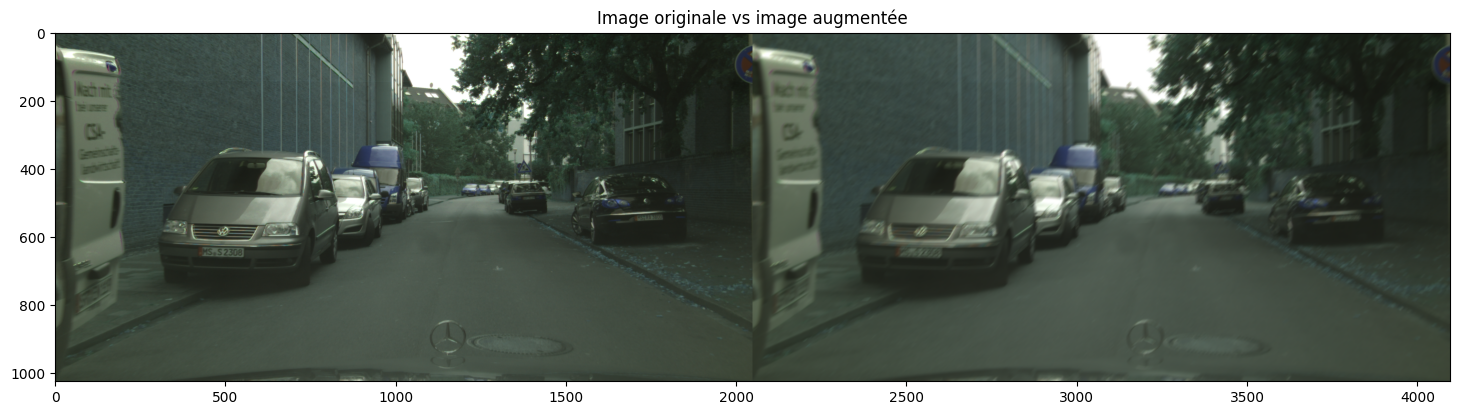

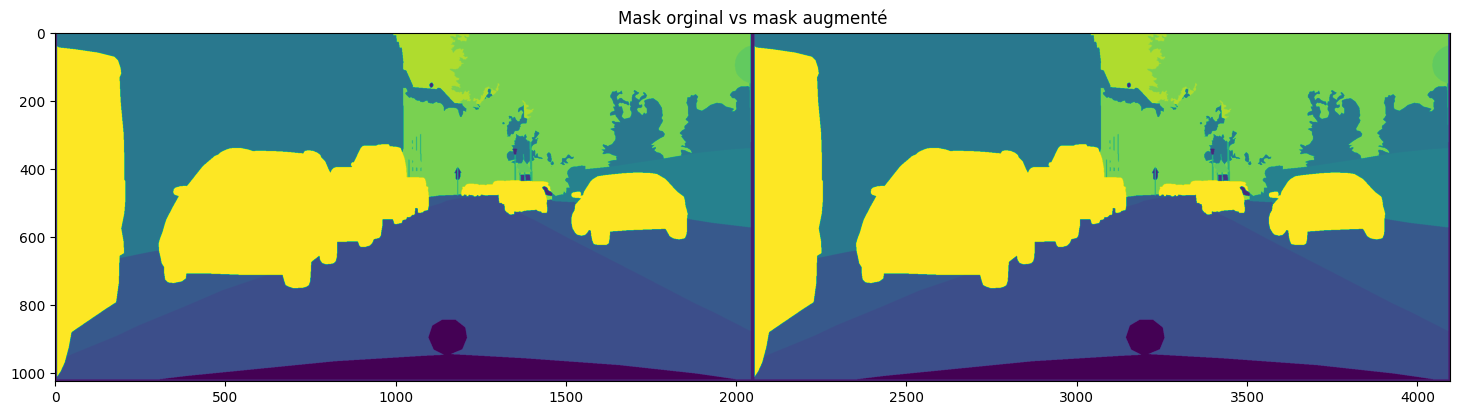

In [50]:
# Définition du chemin d'une photo et de son masque associé
mask_file = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000034_000019_gtFine_labelIds.png"
img_file = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000034_000019_leftImg8bit.png"

# Chargement de la photo et du masque sous forme d'un array
img_array  = cv2.imread(img_file)
mask_array = cv2.imread(mask_file)

# Utilisation de la fonction apply_augmentation_from_array  pour récupérer l'image et le masque augmentés 
image_aug, segmap_aug = apply_augmentation_from_array(mask_array=mask_array, img_array=img_array)

# Affichage de l'image augmentée
plt.figure(figsize=(18,15))
plt.title("Image originale vs image augmentée")
plt.imshow(np.hstack((img_array, image_aug)))
plt.show()

# Affichage du masque augmenté
plt.figure(figsize=(18,15))
plt.title("Mask orginal vs mask augmenté")
plt.imshow(np.hstack((cv2.cvtColor(mask_array, cv2.COLOR_BGR2GRAY), cv2.cvtColor(segmap_aug, cv2.COLOR_BGR2GRAY))))
plt.show()

## <a name="C53">5.3 Générateur<a>

In [51]:
# Générateur sous forme de classe
class sequence_generator(Sequence):
    
    def __init__(self, image_dir,
                 mask_dir,
                 batch_size,
                 img_height,
                 img_width,
                 apply_augmentation,
                 fraction=1):
        
        # image_dir : str, chemin d'accès aux photos
        # mask_dir : str, chamin d'accès aux masques
        # batch_size : int, taille du batch
        # img_height : int, hauteur de l'image, image qui sera utilisée comme entrée pour le modèle
        # img_width : int, largeur de l'image, image qui sera utilisée comme entrée pour le modèle
        # apply_augmentation : boolean, application ou non de l'augmentation 
        # fraction : float, pourcentage du datasat à utiliser pour accélérer l'entrainement. Exemple 50% du dataset  :  fraction = 0.5
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.image_dir = image_dir
        self.mask_dir =  mask_dir
        self.fraction = fraction
        self.apply_augmentation = apply_augmentation
        
        # déclaration des chemins d'accès des images sous forme de liste         
        image_list = glob.glob(os.path.join(image_dir, "*", "*.png"))
        
        # déclaration des chemins d'accès des masques sous forme de liste
        mask_list = glob.glob(os.path.join(mask_dir, "*", "*_gtFine_labelIds.png"))
        
        # Trie des listes dans l'ordre croissant
        image_list.sort()
        mask_list.sort()
        
        # Pour utiliser une portion des images disponibles, déclarer un % 
        # dans ce cas, le générateur choisira des images et masques associées de manières aléatoire         
        if fraction < 1:
            random_indexes = random.choices(range(len(image_list)), k= int(fraction*len(image_list)))
            self.image_list =  [image_list[i] for i in random_indexes]
            self.mask_list =  [mask_list[i] for i in random_indexes]

        else:
            self.image_list =  image_list
            self.mask_list =  mask_list
        
        print("Selection de {} images dans {}".format(len(self.image_list), self.image_dir))
        print("Selection de {} masks dans {}".format(len(self.mask_list), self.mask_dir))
    
    def __len__(self):
        return int(np.ceil(len(self.image_list) / float(self.batch_size)))
    
    # Méthode appelée à chaque fois q'un batch est demandé
    def __getitem__(self, idx):
        'génération un batch avec un index aléatoire'
        
        #Génération d'indexs aléatoire pour le batch        
        idx = np.random.randint(0,len(self.image_list)-1, self.batch_size) 
        
        # Initialisation de listes vides qui contiendront les images et les masques du batch
        batch_img, batch_mask = [], []
        
        # Balayage de tous les idx        
        for i in idx:
            
            # Récupération du nom de l'image et du masque 
            img_file = self.image_list[i]
            mask_file = self.mask_list[i]
            
            
            # Redimensionnement des images pour gagner en temps d'entrainement (l'utilisation des tailles d'origine (1024 x 2048) est possible mais pourrait prendre plus de temps d'entrainement
            img_array  = cv2.resize(cv2.imread(img_file), (self.img_width, self.img_height))
            mask_array = cv2.resize(cv2.imread(mask_file), (self.img_width, self.img_height))
            
                      
            # Application de l'augmentation si argument =True dans la fonction Init (sous forme de classe)
            if self.apply_augmentation:
                image_aug, segmap_aug = apply_augmentation_from_array(mask_array=mask_array, img_array=img_array)
            else:
                segmap_aug = mask_array
                image_aug = img_array
            
            # Conversion du masque en échelle de gris (grayscale)            
            segmap_aug_grey = cv2.cvtColor(segmap_aug, cv2.COLOR_BGR2GRAY)
            
            # Conversion de l'image du masque segmentée en matrice de segmentation 
            mask_aug = get_numpy_mask_from_image(mask_img = segmap_aug_grey)
            
            # Ajout des images et masques à la liste            
            batch_img.append(image_aug)             
            batch_mask.append(mask_aug)   
               
        return np.array(batch_img).astype(np.float32), np.array(batch_mask).astype(np.float32)

In [52]:
#Test du générateur
train_generator = sequence_generator(image_dir  = FOLDER_TRAINING_IMAGES,
                                     mask_dir   = FOLDER_TRAINING_MASK,
                                     batch_size = 16,
                                     img_height = 128,
                                     img_width  = 256,
                                     apply_augmentation = True,
                                     fraction   = 0.05)

Selection de 148 images dans input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train
Selection de 148 masks dans input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train


In [53]:
# format de l'image augmentée
train_generator.__getitem__(idx=1)[0].shape

(16, 128, 256, 3)

In [54]:
# format du masque augmentée
train_generator.__getitem__(idx=1)[1].shape

(16, 128, 256, 8)

In [55]:
test_image = train_generator.__getitem__(idx=1)[0]
test_mask = train_generator.__getitem__(idx=1)[1]

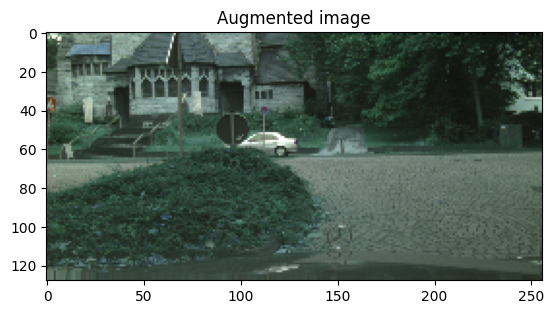

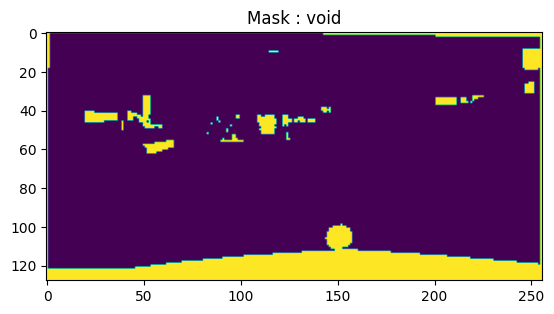

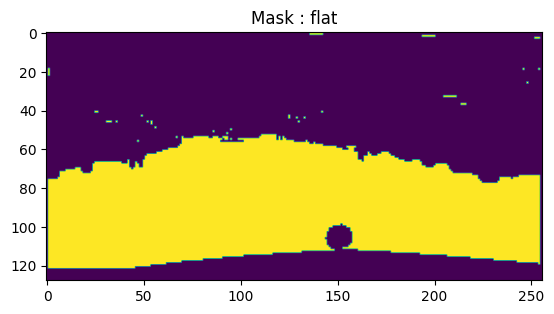

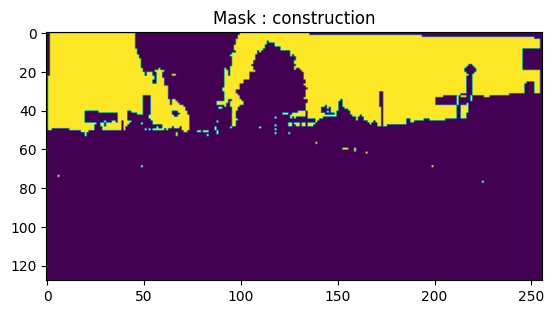

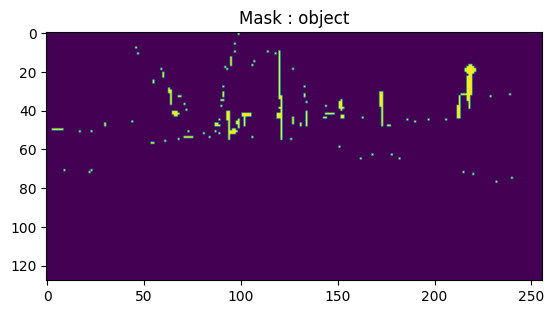

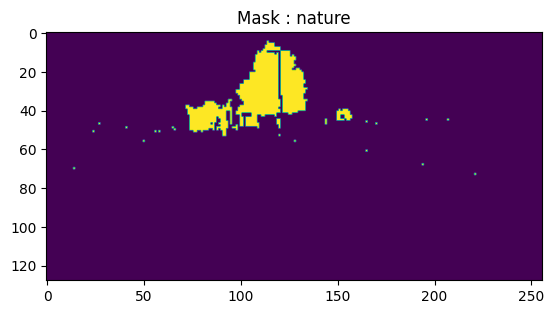

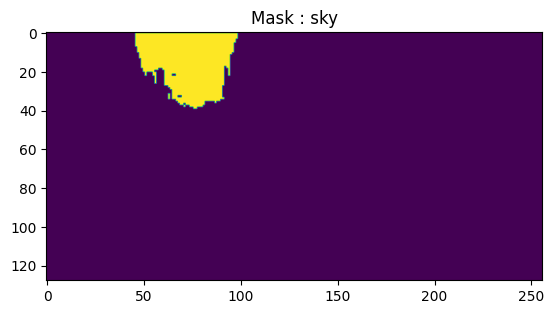

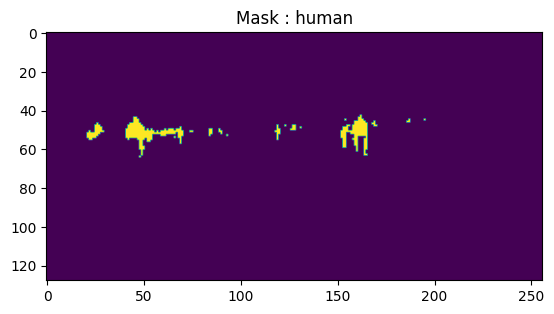

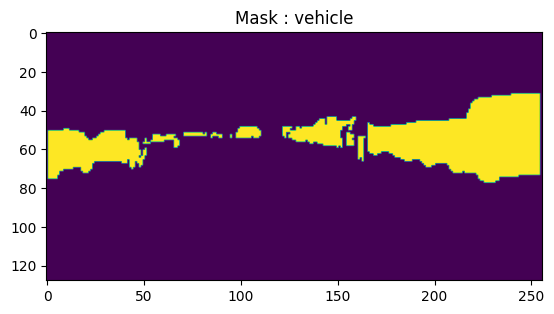

In [56]:
# Visualisation de l'image augmentée
plt.title("Augmented image")
plt.imshow(test_image[0,:,:,:].astype(np.uint8))
plt.show()

# Visualisation de chaque masque
for i in range(8):
    plt.title("Mask : {}".format(id2category[i]))
    plt.imshow(test_mask[0,:,:,i])
    plt.show()

In [57]:

def generate_img_from_mask(mask,colors_palette=['b','g','r','c','m','y','k','w']):
    
    '''Génréation d'une image PIL depuis un masque segmenté et catégorie avec une couleur associée à chacune des catégories
    
    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}
    
    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    
    print("mask size :",mask.shape)
    print("img_seg size :",img_seg.shape)
    
    for cat in id2category.keys():
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]
    
        
    return img_seg

Selection de 148 images dans input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train
Selection de 148 masks dans input/P8_Cityscapes_gtFine_trainvaltest/gtFine/train
mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


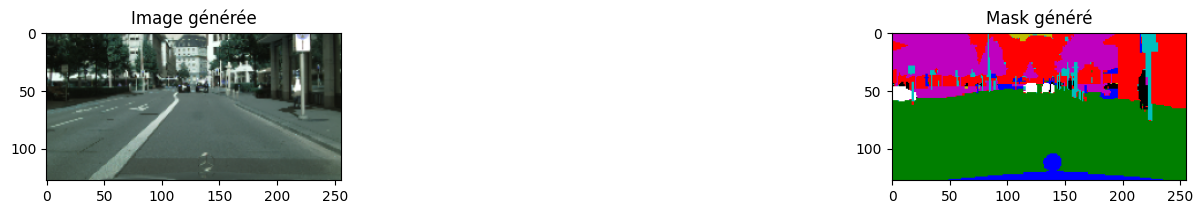

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


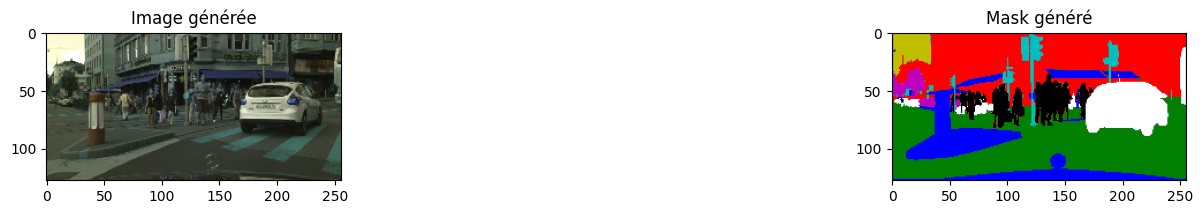

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


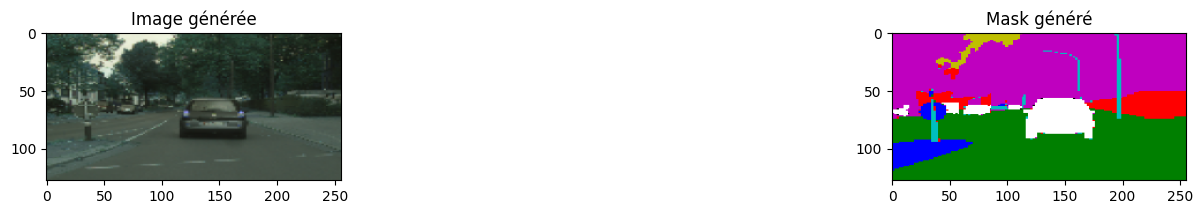

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


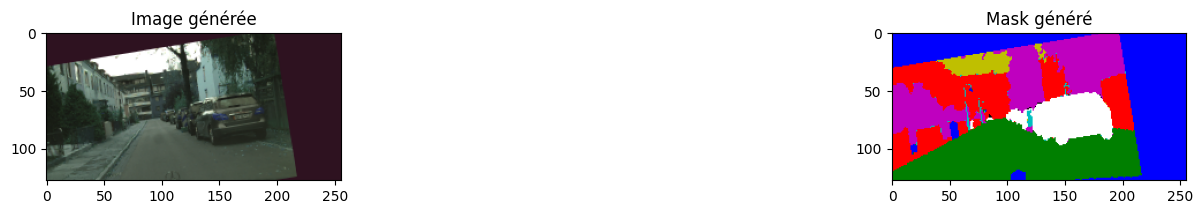

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


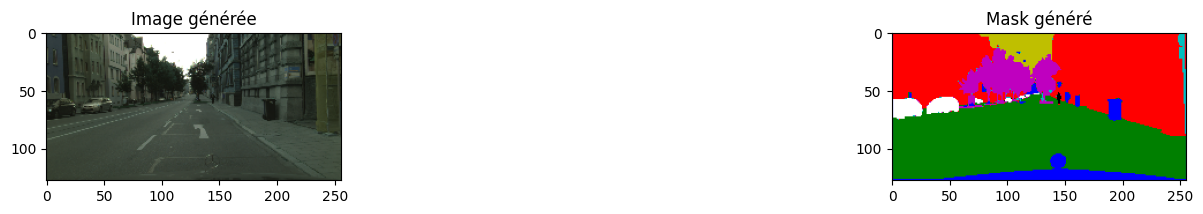

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


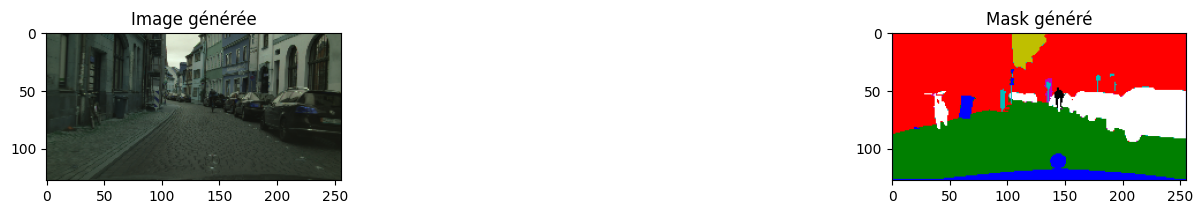

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


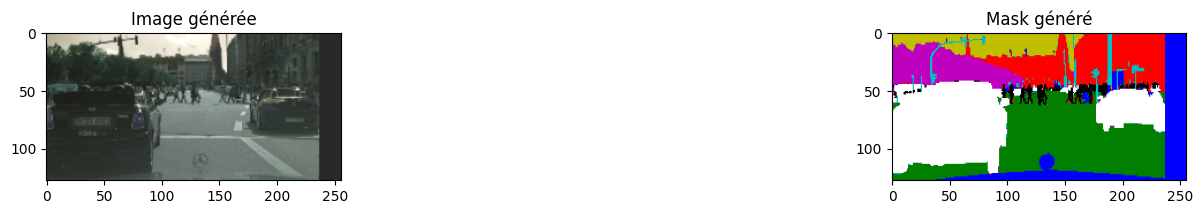

mask size : (128, 256, 8)
img_seg size : (128, 256, 3)


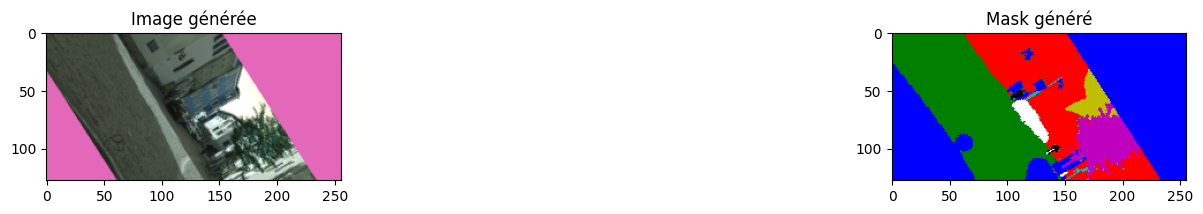

In [58]:
BATCH_SIZE = 8
NCOL = 2

# Instanciation du générateur de séquence
train_generator = sequence_generator(image_dir  = FOLDER_TRAINING_IMAGES,
                                     mask_dir   = FOLDER_TRAINING_MASK,
                                     batch_size = 16,
                                     img_height = 128,
                                     img_width  = 256,
                                     apply_augmentation = True,
                                     fraction   = 0.05)

# Récupération d'une image et de la matrice de segmentation masque associée
img_batch, mask_batch = train_generator.__getitem__(idx=1)

# Passage sur chaque élement du batch
for batch_id in range(BATCH_SIZE):
    
    # Récupération de l'image et du masque correspondant au batch ID
    img = img_batch[batch_id, :, :, :]
    mask = mask_batch[batch_id, :, :, :]
    
    # Récupération du mask coloré depuis la mtrice de segmentation colorée
    mask_img = generate_img_from_mask(mask)
    
    # Affichage des images
    plt.figure(figsize=(20, 18))
    plt.subplot(BATCH_SIZE, NCOL, (batch_id*NCOL)+1)
    plt.imshow(img.astype(np.uint8))
    plt.title("Image générée")
    
    plt.subplot(BATCH_SIZE, NCOL, (batch_id*NCOL)+2)
    plt.imshow(mask_img)
    plt.title("Mask généré")
    
    plt.show()

# <a name="C6">6. Création des modèles<a>

## <a name="C61">6.1 segmentation_models<a>

In [232]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
from segmentation_models import Unet, PSPNet, Linknet, FPN
#from keras_segmentation.models.unet import unet_mini 

### <a name="C611">6.1.1 Sélection des décodeurs<a>

In [233]:
#SEGMENTATION_DICT =  { "pspnet": PSPNet}#,"unet": Unet, "fpn":FPN, "linknet" : Linknet}#{"pspnet": PSPNet}#,  }
#SEGMENTATION_DICT =  { "unet": Unet,"pspnet": PSPNet, "fpn":FPN, "linknet" : Linknet}
SEGMENTATION_DICT =  {"pspnet": PSPNet}

### <a name="C612">6.1.2 Sélection des encodeurs<a>

In [234]:
#BACKBONES_LIST = ["resnet34","mobilenet", 'vgg19']
BACKBONES_LIST = ["resnet34"]
#BACKBONES_LIST = ['resnet152', 'seresnet152', 'seresnext101', 'senet154', 'resnext101', 'vgg19', 'densenet201', 'inceptionresnetv2', 'inceptionv3', 'mobilenet', 'mobilenetv2', 'efficientnetb7']

### <a name="C6.1.3">6.1.3 Sélection des fonctions de perte<a>

In [235]:
from segmentation_models.losses import jaccard_loss, dice_loss, categorical_focal_loss, categorical_crossentropy, cce_dice_loss, cce_jaccard_loss
from tensorflow.keras.losses import Loss

#LOSS_LIST = [jaccard_loss, dice_loss, categorical_crossentropy]#, cce_dice_loss, cce_jaccard_loss]
LOSS_LIST = [jaccard_loss]#, categorical_crossentropy]
#LOSS_LIST = [dice_loss]#,jaccard_loss, categorical_crossentropy,categorical_focal_loss]

### <a name="C614">6.1.4 Définition des callbacks<a>

In [236]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.models import Model

reduce_lr    = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 mode='min', 
                                 patience=10, 
                                 verbose=1, 
                                 cooldown=0, 
                                 min_lr=1e-10)

early_stop   = EarlyStopping(monitor='val_loss', patience=5)

### <a name="C615">6.1.5 Training<a>

In [237]:
# Let's import some relevant function
import tensorflow as tf
print("Tensorflow version is : ", tf.__version__)
from tensorflow.keras.optimizers.legacy import Adam, SGD, RMSprop, Ftrl, Adadelta
from segmentation_models.metrics import iou_score, f1_score, f2_score, precision, recall
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy, BinaryAccuracy#, MeanMetricWrapper
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.metrics import BinaryIoU
#from tensorflow.compat.v1.keras.metrics import BinaryIoU
config = ConfigProto()
config.gpu_options.allow_growth = True #Contrôler l'allocation de mémoire GPU : voir https://learntutorials.net/fr/tensorflow/topic/10621/configuration-du-gpu-tensorflow
session = InteractiveSession(config=config)

# Initialisation des hyperparamètres
EPOCH_NUMBER = 5
BATCH_SIZE = 8
TRAINING_IMAGE_WIDTH = 256
TRAINING_IMAGE_HEIGHT = 128
LEARNING_RATE = 0.01
LEARNING_RATE_DECAY = 0.5
MOMENTUM = 0.9

# Définition des optimisers

sgd = SGD(learning_rate =LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
adam = Adam(learning_rate= LEARNING_RATE*0.1, decay=LEARNING_RATE_DECAY)
rms=RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')
ftrl=Ftrl(learning_rate=0.001,learning_rate_power=-0.5,initial_accumulator_value=0.1,l1_regularization_strength=0.0, l2_regularization_strength=0.0, name='Ftrl', l2_shrinkage_regularization_strength=0.0,beta=0.0)
adadelta=Adadelta(learning_rate=0.001,rho=0.95,epsilon=1e-07,name='Adadelta')


OPTIMIZER_DICT = {"sgd": sgd, "adam":adam}

# Définition de la liste des métriques
METRICS_LIST = [BinaryAccuracy(), BinaryIoU(name="binary_iou"), precision, recall, f1_score]


Tensorflow version is :  2.12.0


C:\Users\Utilisateur\anaconda3\envs\projet8\lib\site-packages\tensorflow\python\client\session.py:1769: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [238]:
def train_model(segmentation_model, segmentation_model_name, 
                backbone_model, loss_type, 
                apply_augmentation, 
                fraction,
               save_format):

    input_size = (TRAINING_IMAGE_WIDTH, TRAINING_IMAGE_HEIGHT)
    
    if segmentation_model == PSPNet:
        if TRAINING_IMAGE_WIDTH%48 != 0 and TRAINING_IMAGE_HEIGHT%48 != 0:
            width  = ((TRAINING_IMAGE_WIDTH//48)+1)*48
            height = ((TRAINING_IMAGE_HEIGHT//48)+1)*48
            
            input_size = (width, height)

    
    print("Début du training du modèle de segmentation {} avec le décodeur {} et des images de taille {}x{}".format(segmentation_model_name, backbone_model, input_size[0], input_size[1]))
    
    # Mise en place du training_model    
    #training_model = segmentation_model(n_classes=8)
    
    training_model = segmentation_model(backbone_model, encoder_weights='imagenet', input_shape=(input_size[1], input_size[0], 3), classes=8)

    #training_model= Model(inputs=training_model.input, outputs=training_model.layers[-3].output)
    training_model.summary()
    
        
    training_model.compile(loss=loss_type, optimizer=rms, metrics=METRICS_LIST)
    #training_model.compile(loss=loss_type, optimizer=opt)

    
    # Création du  train et validation generator pour l'entrainement        
    train_generator = sequence_generator(image_dir  = FOLDER_TRAINING_IMAGES,
                                         mask_dir   = FOLDER_TRAINING_MASK,
                                         batch_size = BATCH_SIZE,
                                         img_height = input_size[1],
                                         img_width  = input_size[0],
                                         apply_augmentation = apply_augmentation,
                                         fraction   = fraction)
    
    validation_generator = sequence_generator(image_dir  = FOLDER_VALIDATION_IMAGES,
                                              mask_dir   = FOLDER_VALIDATION_MASK,
                                              batch_size = BATCH_SIZE,
                                              img_height = input_size[1],
                                              img_width  = input_size[0],
                                              apply_augmentation = False,
                                              fraction   = fraction)
    
    # Création du dossier checkpoint pour l'enregistrement des modèles 
    if not os.path.exists("./checkpoints/"):
        os.mkdir("./checkpoints/")
    #checkpointer = ModelCheckpoint(filepath=os.path.join("./checkpoints", "{}_{}_{}_aug{}_{}.h5".format(backbone_model, segmentation_model_name, loss_type.name, str(apply_augmentation), opt_name)), verbose=1, save_best_only=True)
    
    # Lancement de l'entrainement
    history = training_model.fit(train_generator, epochs=EPOCH_NUMBER, verbose=1, 
                                 callbacks=[reduce_lr, early_stop], 
                                 validation_data=validation_generator,workers=6)#,use_multiprocessing=True)
    
    if save_format=="tf": 
        training_model.save(os.path.join("./checkpoints", "{}_{}_{}_aug{}.tf".format(backbone_model,
                                                                                    segmentation_model_name,
                                                                                    loss_type.name,
                                                                                    str(apply_augmentation)
                                                                                    )), save_format=save_format) #"h5 or tf
    else :
        if save_format=="h5":
            training_model.save(os.path.join("./checkpoints", "{}_{}_{}_aug{}.h5".format(backbone_model,
                                                                                    segmentation_model_name,
                                                                                    loss_type.name,
                                                                                    str(apply_augmentation)
                                                                                    )), save_format=save_format) #"h5 or tf
                
                
    return history

In [239]:
# Test de Création d'un model sous format h5
'''SEGMENTATION_MODEL_TEST = PSPNet
SEGMENTATION_MODEL_NAME_TEST ="pspnet"
BACKBONE_TEST = "resnet34"
LOSS_TYPE_TEST = jaccard_loss#dice_loss
APPLY_AUG_TEST = False
OPTIMIZER_TEST = adam
OPTIMIZER_TEST_NAME = 'adam'
EPOCH_NUMBER = 5
#save_format="h5"

# Lancement de la fonction avec les paramètres ci-dessus 
# Remarque : La fonction retourne un history qui contien un dictionnaire contenant tous les valeurs de métrique pour chaque epoch 
test_history = train_model(segmentation_model      = SEGMENTATION_MODEL_TEST, 
                           segmentation_model_name = SEGMENTATION_MODEL_NAME_TEST, 
                           backbone_model          = BACKBONE_TEST, 
                           loss_type               = LOSS_TYPE_TEST, 
                           apply_augmentation      = APPLY_AUG_TEST, 
                           fraction                = 1,
                          save_format="h5")'''

'SEGMENTATION_MODEL_TEST = PSPNet\nSEGMENTATION_MODEL_NAME_TEST ="pspnet"\nBACKBONE_TEST = "resnet34"\nLOSS_TYPE_TEST = jaccard_loss#dice_loss\nAPPLY_AUG_TEST = False\nOPTIMIZER_TEST = adam\nOPTIMIZER_TEST_NAME = \'adam\'\nEPOCH_NUMBER = 5\n#save_format="h5"\n\n# Lancement de la fonction avec les paramètres ci-dessus \n# Remarque : La fonction retourne un history qui contien un dictionnaire contenant tous les valeurs de métrique pour chaque epoch \ntest_history = train_model(segmentation_model      = SEGMENTATION_MODEL_TEST, \n                           segmentation_model_name = SEGMENTATION_MODEL_NAME_TEST, \n                           backbone_model          = BACKBONE_TEST, \n                           loss_type               = LOSS_TYPE_TEST, \n                           apply_augmentation      = APPLY_AUG_TEST, \n                           fraction                = 1,\n                          save_format="h5")'

In [240]:
'''# Avant de lancer la création de tous les modèles, créons juste un modèle pour le test 
SEGMENTATION_MODEL_TEST = Unet#FPN
SEGMENTATION_MODEL_NAME_TEST ="unet"#"fpn"
BACKBONE_TEST = "resnet34"
LOSS_TYPE_TEST = categorical_crossentropy
APPLY_AUG_TEST = False
OPTIMIZER_TEST = adam
OPTIMIZER_TEST_NAME = 'adam'
EPOCH_NUMBER = 1
save_format="tf"

# Lancement de la fonction avec les paramètres ci-dessus 
# Remarque : La fonction retourne un history qui contien un dictionnaire contenant tous les valeurs de métrique pour chaque epoch 
test_history = train_model(segmentation_model      = SEGMENTATION_MODEL_TEST, 
                           segmentation_model_name = SEGMENTATION_MODEL_NAME_TEST, 
                           backbone_model          = BACKBONE_TEST, 
                           loss_type               = LOSS_TYPE_TEST, 
                           apply_augmentation      = APPLY_AUG_TEST, 
                           fraction                = 0.01,
                          save_format="tf")'''
                           

'# Avant de lancer la création de tous les modèles, créons juste un modèle pour le test \nSEGMENTATION_MODEL_TEST = Unet#FPN\nSEGMENTATION_MODEL_NAME_TEST ="unet"#"fpn"\nBACKBONE_TEST = "resnet34"\nLOSS_TYPE_TEST = categorical_crossentropy\nAPPLY_AUG_TEST = False\nOPTIMIZER_TEST = adam\nOPTIMIZER_TEST_NAME = \'adam\'\nEPOCH_NUMBER = 1\nsave_format="tf"\n\n# Lancement de la fonction avec les paramètres ci-dessus \n# Remarque : La fonction retourne un history qui contien un dictionnaire contenant tous les valeurs de métrique pour chaque epoch \ntest_history = train_model(segmentation_model      = SEGMENTATION_MODEL_TEST, \n                           segmentation_model_name = SEGMENTATION_MODEL_NAME_TEST, \n                           backbone_model          = BACKBONE_TEST, \n                           loss_type               = LOSS_TYPE_TEST, \n                           apply_augmentation      = APPLY_AUG_TEST, \n                           fraction                = 0.01,\n              

In [241]:
# Déclaration du chemin vers le fichier où seront enregistrées les performances 
PERFORMANCE_LOG_FILE = "./training_summary.csv"
EPOCH_NUMBER = 50#5

if not os.path.exists(PERFORMANCE_LOG_FILE):
    with open(PERFORMANCE_LOG_FILE, "a") as f:
        f.write("{},{},{},{},{},{},{},{},{},{}\n".format("segmentation_model_name", 
                                                             "backbone_model", 
                                                             "loss_type", 
                                                             "apply_augmentation",
                                                             "training_time (minutes)",
                                                             "val_loss", 
                                                             "val_binary_iou", 
                                                             "val_accuracy", 
                                                             "val_precision", 
                                                             "val_recall"
                                                        ))

# Boucle sur tous les paramètres
for segmentation_model_name, segmentation_model in SEGMENTATION_DICT.items():
    for backbone_model in BACKBONES_LIST:
        for loss_type in LOSS_LIST:
            for apply_augmentation in [True]:#False,
                
                    t0 = time.time()
                    history = train_model(segmentation_model=segmentation_model, 
                                             segmentation_model_name=segmentation_model_name, 
                                             backbone_model=backbone_model,
                                             loss_type=loss_type,
                                             apply_augmentation=apply_augmentation, 
                                             fraction=1,
                                             save_format="tf")
                    training_time = int(time.time() - t0)

                    with open(PERFORMANCE_LOG_FILE, "a") as f:
                        f.write("{},{},{},{},{},{},{},{},{},{}\n".format(segmentation_model_name, 
                                                                             backbone_model, 
                                                                             loss_type.name, 
                                                                             apply_augmentation, 
                                                                             training_time/60,
                                                                             max(history.history["val_loss"]), 
                                                                             max(history.history["val_binary_iou"]), 
                                                                             max(history.history["val_binary_accuracy"]),
                                                                             max(history.history["val_precision"]), 
                                                                             max(history.history["val_recall"]
                                                                        )))

Début du training du modèle de segmentation pspnet avec le décodeur resnet34 et des images de taille 288x144
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 144, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 144, 288, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_238 (ZeroPaddin  (None, 150, 294, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                            

INFO:tensorflow:Assets written to: ./checkpoints\resnet34_pspnet_jaccard_loss_augTrue.tf\assets


INFO:tensorflow:Assets written to: ./checkpoints\resnet34_pspnet_jaccard_loss_augTrue.tf\assets


In [242]:
print(history.history.keys())

dict_keys(['loss', 'binary_accuracy', 'binary_iou', 'precision', 'recall', 'f1-score', 'val_loss', 'val_binary_accuracy', 'val_binary_iou', 'val_precision', 'val_recall', 'val_f1-score', 'lr'])


### 6.1.6 Résultats

In [243]:
# Chargement du chemin d'accès vers le fichier de performance
PERFORMANCE_LOG_FILE = "./training_summary.csv"

# Ouverture du fichir de performance et fusion des colonnes model et encodeur pour faciliter la visualisation sur le graphe 
results_df = pd.read_csv(PERFORMANCE_LOG_FILE)
results_df["model"] = results_df['segmentation_model_name'].astype(str) +" - "+ results_df["backbone_model"].astype(str)
results_df.drop(["segmentation_model_name", "backbone_model"], inplace=True, axis=1)

In [244]:
#Filtrage des colonnes souhaitée pour la mise en forme des graphes

results_df["training_time (minutes)"]=round(results_df["training_time (minutes)"],2)
results_df["val_accuracy"]=round(results_df["val_accuracy"],2)
results_df["val_loss"]=round(results_df["val_loss"],2)
results_df["val_binary_iou"]=round(results_df["val_binary_iou"],2)
results_df["val_precision"]=round(results_df["val_precision"],2)
results_df["val_recall"]=round(results_df["val_recall"],2)


'''results_df=results_df.loc[(results_df["loss_type"]=="jaccard_loss")]
results_df=results_df.loc[(results_df["model"]=="pspnet - resnet34"),:]'''


results_df.head()



loss_type  apply_augmentation  training_time (minutes)  val_loss   
0  jaccard_loss                True                    147.5      0.52  \

   val_binary_iou  val_accuracy  val_precision  val_recall              model  
0            0.86          0.97           0.79        0.74  pspnet - resnet34

In [245]:
results_df.head(50)

loss_type  apply_augmentation  training_time (minutes)  val_loss   
0  jaccard_loss                True                    147.5      0.52  \

   val_binary_iou  val_accuracy  val_precision  val_recall              model  
0            0.86          0.97           0.79        0.74  pspnet - resnet34

In [246]:
def display_benchmark_per_metric(metric_name):
    # Filtrage de la df sur les metriques 
    filtered_df = results_df[["model", "loss_type", "apply_augmentation", metric_name]]
    
    # Affichage des histogrammes de performances 
    #plt.figure(figsize=(50, 300))
   
    g = sns.catplot(x="model", y=metric_name,hue="apply_augmentation", col="loss_type", 
                    data=filtered_df, kind="bar",height=3, aspect=2)
    g.set_xticklabels(rotation=90) 
    
    g.fig.subplots_adjust(top=0.7)
    g.fig.suptitle('Benchmarking des modèles pour {}'.format(metric_name).upper())
    
    #Ajout des annotation sur les axes
    for ax in g.axes.ravel():
        for c in ax.containers:
            ax.bar_label(c, label_type='edge')
        ax.margins(y=0.2)

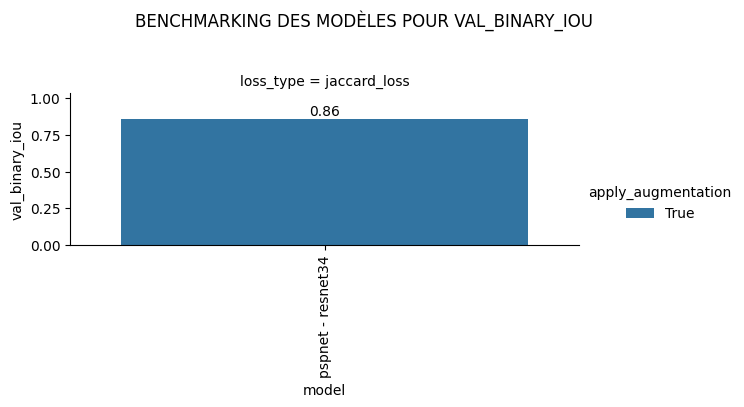

In [247]:
display_benchmark_per_metric(metric_name="val_binary_iou")

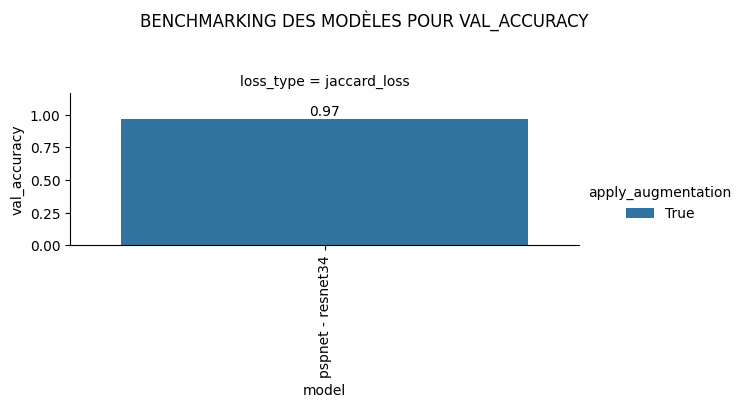

In [248]:
display_benchmark_per_metric(metric_name="val_accuracy")

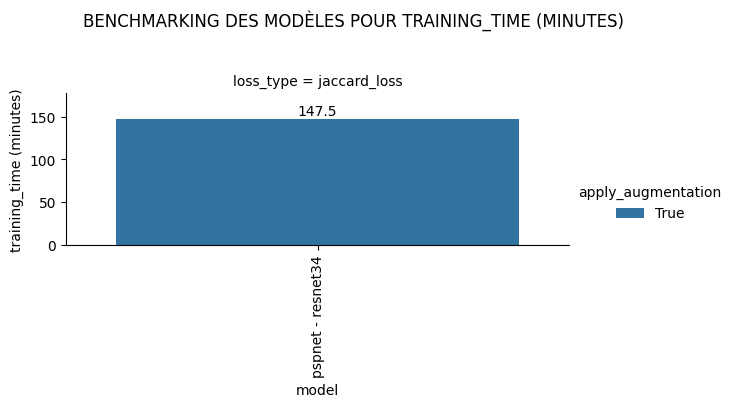

In [249]:
display_benchmark_per_metric(metric_name="training_time (minutes)")

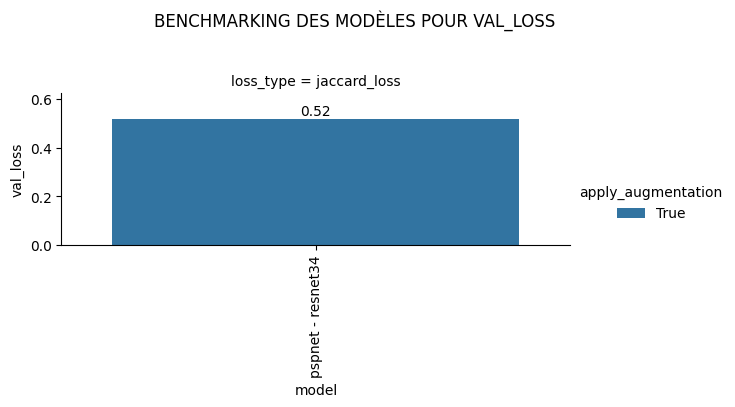

In [250]:
display_benchmark_per_metric(metric_name="val_loss")

In [251]:
#display_benchmark_per_metric(metric_name="val_precision")

In [252]:
#display_benchmark_per_metric(metric_name="val_recall")

In [253]:
STOP

NameError: name 'STOP' is not defined

# 7. Exploitation du meilleur modèle

## 7.1 Affichage de résultats de prédiction

In [327]:
def conversion_h5(pb_model_dir ,h5_model,custom_objects):
    
    model = tf.keras.models.load_model(pb_model_dir,custom_objects)
    print("Format Tensorflow .pb")
    print(model.summary())

    # Saving the Model in H5 Format
    tf.keras.models.save_model(model, h5_model)

    # Loading the H5 Saved Model
    loaded_model_from_h5 = tf.keras.models.load_model(h5_model, custom_objects)
    print("Format Keras .h5")
    print(loaded_model_from_h5.summary())
    
       
    
    return loaded_model_from_h5
    

In [328]:
pb_model_dir = "D:/PROJET8/modeles/20230612_resnet34_pspnet_jaccard_loss_augTrue_binary_iou_rms_epoch20_86.tf"
h5_model = "D:/PROJET8/modeles/20230612_resnet34_pspnet_jaccard_loss_augTrue_binary_iou_rms_epoch20_86.tf/mymodel.h5"
custom_objects={'dice_loss': dice_loss, 'jaccard_loss': jaccard_loss, 'precision': precision, 'recall': recall,'f1-score': f1_score}

loaded_model_from_h5=conversion_h5(pb_model_dir ,h5_model, custom_objects)

Format Tensorflow .pb
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 144, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 144, 288, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_238 (ZeroPaddin  (None, 150, 294, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                     

In [329]:
def affichage_model_result(img_test,loaded_model_from_h5):
    
    img_test_array  = cv2.imread(img_test)
    #plt.imshow(img_test_array)
    #print(img_test_array.shape)
    
    resized = cv2.resize(img_test_array,(288,144))#, interpolation = cv2.INTER_AREA)
    plt.imshow(resized )
    #print(resized.shape)
    
    resized = np.expand_dims(resized, axis = 0)
    #print(resized.shape)
    
    mask_u = loaded_model_from_h5.predict(resized)
    #mask_u.shape
    
    print(id2category.keys())
    
    for i in range(8):
        plt.title("Mask : {}".format(id2category[i]))
        plt.imshow(mask_u[0,:,:,i])
        plt.show()
        
    #print(mask_u.shape)
    
    a_s = np.squeeze(mask_u)
    #print(a_s.shape)
    
    #img_seg = np.zeros((a_s.shape[0],a_s.shape[1],3),dtype='float')
    #print(img_seg.shape)
    #print(a_s.shape)
    
    mask_t=generate_img_from_mask(a_s)
    #print(mask_t)
    plt.imshow(mask_t)
    
    return mask_t
    

    

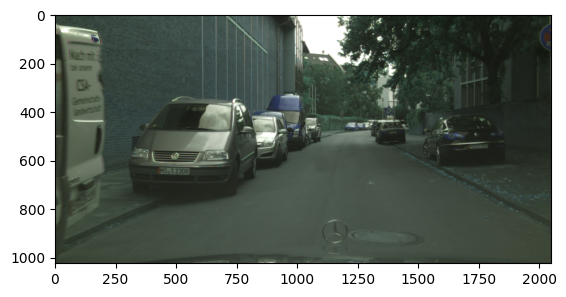

In [330]:
# Chargement de l'image à utiliser pour la prédiction.

img_test = "input/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val/munster/munster_000034_000019_leftImg8bit.png"

img_test_array  = cv2.imread(img_test)
plt.imshow(img_test_array)



1/1 [==============================] - 0s 380ms/step
dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


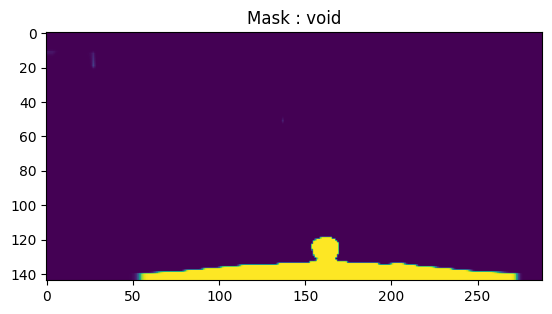

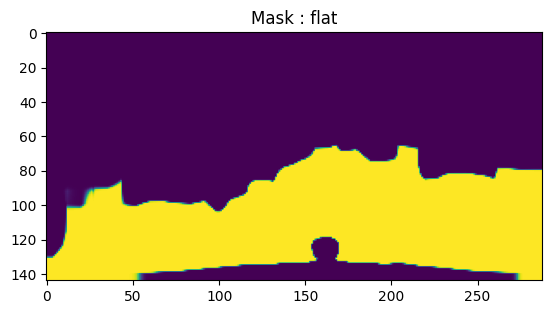

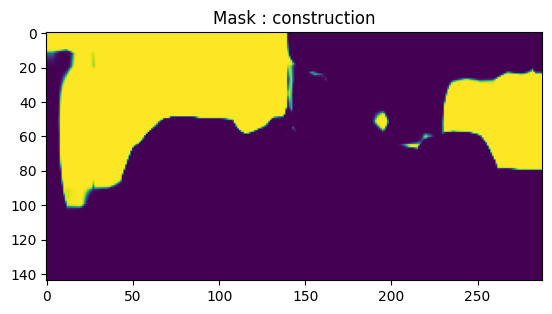

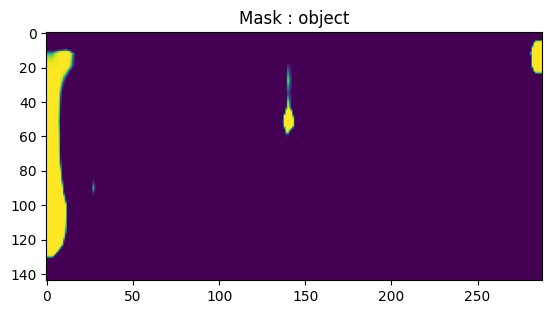

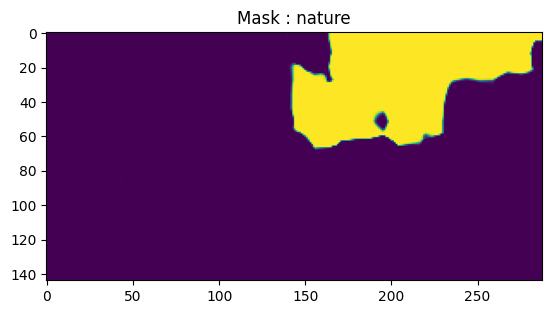

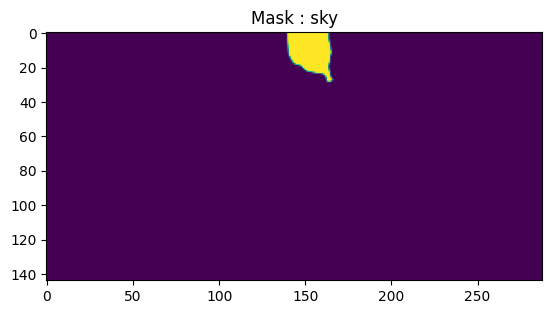

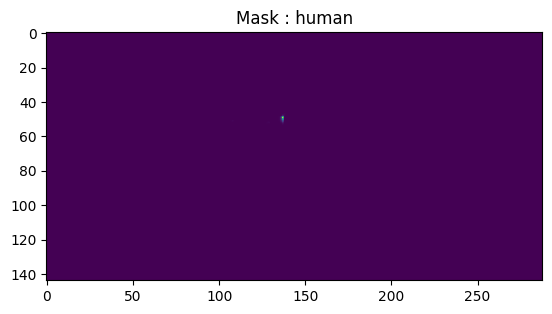

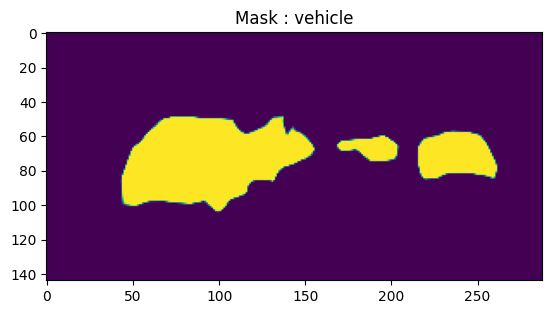

mask size : (144, 288, 8)
img_seg size : (144, 288, 3)


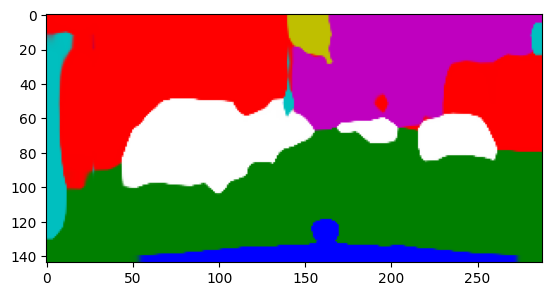

In [331]:
mask_t=affichage_model_result(img_test,loaded_model_from_h5)

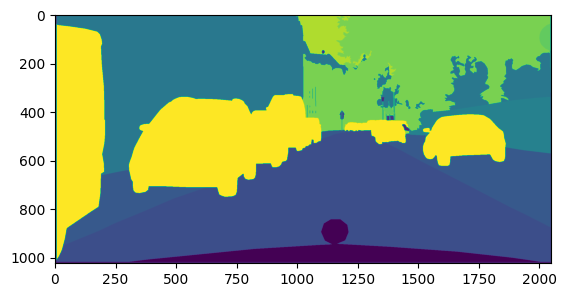

In [332]:
mask_test = "input/P8_Cityscapes_gtFine_trainvaltest/gtFine/val/munster/munster_000034_000019_gtFine_labelIds.png"
mask_test_array = cv2.imread(mask_test)
plt.imshow(((cv2.cvtColor(mask_test_array, cv2.COLOR_BGR2GRAY))))

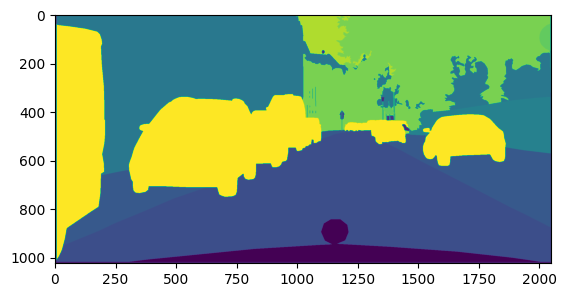

In [333]:
mask_test_array_color=cv2.cvtColor(mask_test_array, cv2.COLOR_BGR2GRAY)
plt.imshow(mask_test_array_color)

In [334]:
#STOP

## 7.2 Réentrainement du modèle

### 7.2.1 Chargement des paramètres

In [335]:
def re_train_model(training_model,segmentation_model, segmentation_model_name, 
                backbone_model, loss_type, 
                apply_augmentation, 
                fraction,
               save_format):

    input_size = (TRAINING_IMAGE_WIDTH, TRAINING_IMAGE_HEIGHT)
    
    if segmentation_model == PSPNet:
        if TRAINING_IMAGE_WIDTH%48 != 0 and TRAINING_IMAGE_HEIGHT%48 != 0:
            width  = ((TRAINING_IMAGE_WIDTH//48)+1)*48
            height = ((TRAINING_IMAGE_HEIGHT//48)+1)*48
            
            input_size = (width, height)

    
    print("Début du retraining du modèle de segmentation {} avec le décodeur {} et des images de taille {}x{}".format(segmentation_model_name, backbone_model, input_size[0], input_size[1]))
    
    # Mise en place du training_model    
    #training_model = segmentation_model(n_classes=8)
    
    #training_model = segmentation_model(backbone_model, encoder_weights='imagenet', input_shape=(input_size[1], input_size[0], 3), classes=8)

    #training_model= Model(inputs=training_model.input, outputs=training_model.layers[-3].output)
    training_model.summary()
    
        
    training_model.compile(loss=loss_type, optimizer=rms, metrics=METRICS_LIST)
    #training_model.compile(loss=loss_type, optimizer=opt)

    
    # Création du  train et validation generator pour l'entrainement        
    train_generator = sequence_generator(image_dir  = FOLDER_TRAINING_IMAGES,
                                         mask_dir   = FOLDER_TRAINING_MASK,
                                         batch_size = BATCH_SIZE,
                                         img_height = input_size[1],
                                         img_width  = input_size[0],
                                         apply_augmentation = apply_augmentation,
                                         fraction   = fraction)
    
    validation_generator = sequence_generator(image_dir  = FOLDER_VALIDATION_IMAGES,
                                              mask_dir   = FOLDER_VALIDATION_MASK,
                                              batch_size = BATCH_SIZE,
                                              img_height = input_size[1],
                                              img_width  = input_size[0],
                                              apply_augmentation = False,
                                              fraction   = fraction)
    
    # Création du dossier checkpoint pour l'enregistrement des modèles 
    if not os.path.exists("./checkpoints/retrained"):
        os.mkdir("./checkpoints/retrained")
    #checkpointer = ModelCheckpoint(filepath=os.path.join("./checkpoints", "{}_{}_{}_aug{}_{}.h5".format(backbone_model, segmentation_model_name, loss_type.name, str(apply_augmentation), opt_name)), verbose=1, save_best_only=True)
    
    # Lancement de l'entrainement
    history = training_model.fit(train_generator, epochs=EPOCH_NUMBER, verbose=1, 
                                 callbacks=[reduce_lr, early_stop], 
                                 validation_data=validation_generator,workers=6)#,use_multiprocessing=True)
    
    if save_format=="tf": 
        training_model.save(os.path.join("./checkpoints/retrained", "{}_{}_{}_aug{}.tf".format(backbone_model,
                                                                                    segmentation_model_name,
                                                                                    loss_type.name,
                                                                                    str(apply_augmentation)
                                                                                    )), save_format=save_format) #"h5 or tf
    else :
        if save_format=="h5":
            training_model.save(os.path.join("./checkpoints/retrained", "{}_{}_{}_aug{}.h5".format(backbone_model,
                                                                                    segmentation_model_name,
                                                                                    loss_type.name,
                                                                                    str(apply_augmentation)
                                                                                    )), save_format=save_format) #"h5 or tf
                
                
    return history

In [336]:
PERFORMANCE_LOG_FILE_retrained = "./retraining_summary.csv"


if not os.path.exists(PERFORMANCE_LOG_FILE_retrained):
    with open(PERFORMANCE_LOG_FILE_retrained, "a") as f:
        f.write("{},{},{},{},{},{},{},{},{},{}\n".format("segmentation_model_name", 
                                                             "backbone_model", 
                                                             "loss_type", 
                                                             "apply_augmentation",
                                                             "training_time (minutes)",
                                                             "val_loss", 
                                                             "val_binary_iou", 
                                                             "val_accuracy", 
                                                             "val_precision", 
                                                             "val_recall"
                                                        ))

In [ ]:
SEGMENTATION_MODEL_TEST = PSPNet#FPN
SEGMENTATION_MODEL_NAME_TEST ="pspnet"#"fpn"
BACKBONE_TEST = "resnet34"
LOSS_TYPE_TEST = jaccard_loss
APPLY_AUG_TEST = True
OPTIMIZER_TEST = rms
OPTIMIZER_TEST_NAME = 'rms'#'sgd'#'adam'
EPOCH_NUMBER = 5
save_format="tf"

nb_train = 2

# Lancement de la fonction avec les paramètres ci-dessus 
# Remarque : La fonction retourne un history qui contient un dictionnaire contenant tous les valeurs de métrique pour chaque epoch 

loaded_model_from_h5_retrained=loaded_model_from_h5

for i in range(nb_train) :
    
    t0=time.time()
    test_history = re_train_model(training_model= loaded_model_from_h5_retrained,segmentation_model      = SEGMENTATION_MODEL_TEST, 
                               segmentation_model_name = SEGMENTATION_MODEL_NAME_TEST, 
                               backbone_model          = BACKBONE_TEST, 
                               loss_type               = LOSS_TYPE_TEST, 
                               apply_augmentation      = APPLY_AUG_TEST, 
                               fraction                = 1,
                              save_format="tf")
    training_time = int(time.time() - t0)
    
    pb_model_dir_retrained = "./checkpoints/retrained/resnet34_pspnet_jaccard_loss_augTrue.tf"
    h5_model_retrained = "./checkpoints/retrained/resnet34_pspnet_jaccard_loss_augTrue.tf/mymodel.h5"
    custom_objects={'dice_loss': dice_loss, 'jaccard_loss': jaccard_loss, 'precision': precision, 'recall': recall,'f1-score': f1_score}
    loaded_model_from_h5_retrained=conversion_h5(pb_model_dir_retrained ,h5_model_retrained, custom_objects)

    with open(PERFORMANCE_LOG_FILE_retrained, "a") as f:

                            f.write("{},{},{},{},{},{},{},{},{},{}\n".format(segmentation_model_name, 
                                                                                 BACKBONE_TEST, 
                                                                                 LOSS_TYPE_TEST.name, 
                                                                                 APPLY_AUG_TEST, 
                                                                                 training_time/60,
                                                                                 max(test_history.history["val_loss"]), 
                                                                                 max(test_history.history["val_binary_iou"]), 
                                                                                 max(test_history.history["val_binary_accuracy"]),
                                                                                 max(test_history.history["val_precision"]), 
                                                                                 max(test_history.history["val_recall"]
                                                                            )))

Début du retraining du modèle de segmentation pspnet avec le décodeur resnet34 et des images de taille 288x144
Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 144, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 144, 288, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_238 (ZeroPaddin  (None, 150, 294, 3)  0          ['bn_data[0][0]']                
 g2D)                                                                          

### 7.2.2 Affichage des résultats

In [ ]:
PERFORMANCE_LOG_FILE_retrained = "./retraining_summary.csv"
results_df_retrained = pd.read_csv(PERFORMANCE_LOG_FILE_retrained)
results_df_retrained["model"] = results_df_retrained['segmentation_model_name'].astype(str) +" - "+ results_df_retrained["backbone_model"].astype(str)
results_df_retrained.drop(["segmentation_model_name", "backbone_model"], inplace=True, axis=1)

In [ ]:
#Filtrage des colonnes souhaitée pour la mise en forme des graphes

results_df_retrained["training_time (minutes)"]=round(results_df_retrained["training_time (minutes)"],2)
results_df_retrained["val_accuracy"]=round(results_df_retrained["val_accuracy"],2)
results_df_retrained["val_loss"]=round(results_df_retrained["val_loss"],2)
results_df_retrained["val_binary_iou"]=round(results_df_retrained["val_binary_iou"],2)
results_df_retrained["val_precision"]=round(results_df_retrained["val_precision"],2)
results_df_retrained["val_recall"]=round(results_df_retrained["val_recall"],2)


'''results_df=results_df.loc[(results_df["loss_type"]=="jaccard_loss")]
results_df=results_df.loc[(results_df["model"]=="pspnet - resnet34"),:]'''


results_df_retrained.head(50)

In [ ]:
def display_benchmark_per_metric_retrained(metric_name):
    # Filtrage de la df sur les metriques 
    filtered_df_retrained = results_df_retrained[["model", "loss_type", "apply_augmentation", metric_name]]
    
    # Affichage des histogrammes de performances 
    #plt.figure(figsize=(50, 300))
   
    g = sns.catplot(x="model", y=metric_name,hue="apply_augmentation", col="loss_type", 
                    data=filtered_df_retrained, kind="bar",height=3, aspect=2)
    g.set_xticklabels(rotation=90) 
    
    g.fig.subplots_adjust(top=0.7)
    g.fig.suptitle('Benchmarking des modèles pour {}'.format(metric_name).upper())
    
    #Ajout des annotation sur les axes
    for ax in g.axes.ravel():
        for c in ax.containers:
            ax.bar_label(c, label_type='edge')
        ax.margins(y=0.2)

In [ ]:
display_benchmark_per_metric_retrained(metric_name="val_binary_iou")

In [ ]:
display_benchmark_per_metric_retrained(metric_name="training_time (minutes)")

# FIN